# Anomaly Detection

## Importing the input vectors

In [205]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import shap
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from functools import partial
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from datetime import datetime

# Run the data preparation notebook
#testdf = np.load("npy_files/X_input.npy", allow_pickle=True)
testdf = np.load("npy_files/X_input.npy", allow_pickle=True)

X_input = testdf[:-1,:-2].astype(np.float32)
anomaly_list = testdf[:-1,-1] #0 for normal. 1 for anomaly
timestamps = testdf[:-1,-2]
timestamps = pd.to_datetime(timestamps)

In [206]:
type(anomaly_list)

numpy.ndarray

In [207]:
intervals = [ 
    (datetime(2020, 4, 18, 0, 0), datetime(2020, 4, 18, 23, 59)),
    (datetime(2020, 5, 29, 23, 30), datetime(2020, 5, 30, 6, 0)),
    (datetime(2020, 6, 5, 10, 0), datetime(2020, 6, 7, 14, 30)),
    (datetime(2020, 7, 15, 14, 30), datetime(2020, 7, 15, 19, 0))
]
anomaly_list = [1 if any(start <= ts <= end for start, end in intervals) else 0 for ts in timestamps]
anomaly_list = np.array(anomaly_list, dtype=bool)

In [208]:
#Take just the analog part
#X_input = X_input[:,49:]

In [209]:
pd.DataFrame(timestamps).head()

,0
0,2020-02-01 00:23:08
1,2020-02-01 00:57:19
2,2020-02-01 01:30:41
3,2020-02-01 02:04:23
4,2020-02-01 02:37:54


In [210]:
X_input.shape

(11626, 100)

In [211]:
pd.DataFrame(X_input).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,8.978,10.110,-0.012,-0.014,-0.014,-0.014,-0.014,8.642,9.736,9.728,...,40.0,5.0,6.0,39.0,39.0,39.0,39.0,40.0,109.0,1942.0
1,8.894,10.028,-0.012,-0.012,-0.014,-0.014,-0.014,8.552,9.644,9.706,...,39.0,4.0,6.0,38.0,38.0,39.0,38.0,39.0,99.0,1903.0
2,8.816,10.164,-0.014,-0.012,-0.014,-0.014,-0.014,8.474,9.788,9.716,...,39.0,4.0,6.0,38.0,39.0,39.0,39.0,39.0,99.0,1923.0
3,9.060,8.848,-0.014,-0.014,-0.014,-0.014,-0.016,8.720,9.858,9.710,...,39.0,5.0,5.0,38.0,39.0,38.0,39.0,39.0,99.0,1912.0
4,8.930,9.918,-0.012,-0.012,-0.014,-0.014,-0.014,8.506,9.602,9.716,...,39.0,5.0,5.0,38.0,38.0,37.0,38.0,39.0,100.0,1883.0


In [212]:
X_input.shape

(11626, 100)

#### Deciding the different sets' sizes and positions

#### Defining Autoencoder, loss and prediction functions

In [213]:
# Define input dimension
input_dim = X_input.shape[1]

'''# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(128, activation='sigmoid', name='encoder_layer1')(input_layer)
encoded = Dense(64, activation='sigmoid', name='encoder_layer2')(encoded)
encoded = Dense(32, activation='sigmoid', name='encoder_layer3')(encoded)
bottleneck = Dense(12, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(32, activation='sigmoid', name='decoder_layer1')(bottleneck)
decoded = Dense(64, activation='sigmoid', name='decoder_layer2')(decoded)
decoded = Dense(128, activation='sigmoid', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)'''

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(256, activation='sigmoid', name='encoder_layer1')(input_layer)
encoded = Dense(128, activation='sigmoid', name='encoder_layer2')(encoded)
encoded = Dense(64, activation='sigmoid', name='encoder_layer3')(encoded)
bottleneck = Dense(16, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(64, activation='sigmoid', name='decoder_layer1')(bottleneck)
decoded = Dense(128, activation='sigmoid', name='decoder_layer2')(decoded)
decoded = Dense(256, activation='sigmoid', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)
autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss
    

# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions, pos_label=0)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions, pos_label=0)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions, pos_label=0)))

def precision_recall_curve_exclusive(y_true, scores):
    # Get all unique score values as candidate thresholds
    thresholds = np.unique(scores)
    precisions = []
    recalls = []

    for thresh in thresholds:
        # New thresholding rule: exclusive
        y_pred = scores > thresh
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred))

    return np.array(recalls), np.array(precisions), thresholds

## Running the Autoencoder

#### Operator to tell the first cycle of a given month

In [214]:
print(timestamps[0])
print(timestamps[-1])

2020-02-01 00:23:08
2020-09-01 02:57:53


In [215]:
np.where(timestamps >= '2020-02-01')[0][0]

np.int64(0)

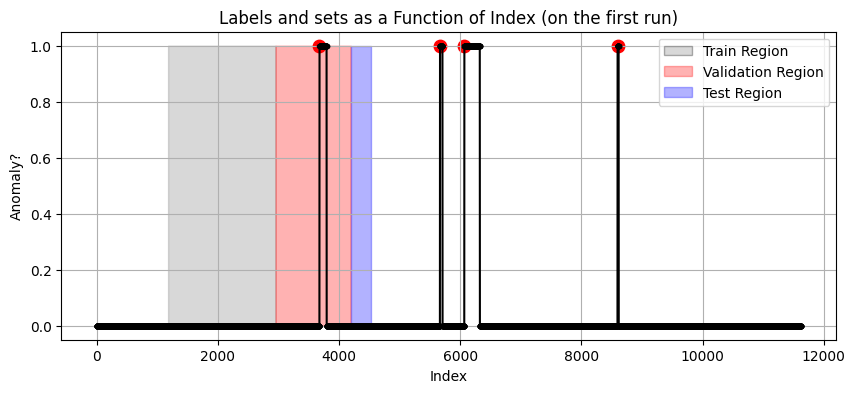

In [216]:
labels_int = [int(label) for label in anomaly_list]

# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
index_mar = 1180+1 #March 1st index (+1 bc 1st cycle is problematic)
index_apr = 2954
index_mai = 4193 
index_jun = 5815
index_jul = 7611
time_delta = 7 # how many days at a time you want to test
last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=time_delta)) #Determine the last index of the test set
last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=2*time_delta))

# Plot the labels as a function of the index
plt.figure(figsize=(10, 4))
plt.plot(labels_int, '.-', color='black', label='Labels')
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= index_mar) & (np.arange(len(anomaly_list)) < index_apr), color='gray', alpha=0.3)
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= index_apr) & (np.arange(len(anomaly_list)) < index_mai), color='red', alpha=0.3)
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= index_mai)& (np.arange(len(anomaly_list)) < last_test_index), color='blue', alpha=0.3)
highlight_x = [3679, 5667, 6069, 8597]
highlight_y = [1, 1, 1, 1]
plt.scatter(highlight_x, highlight_y, color='red', s=80, marker='o', label='Failures')
legend_elements = [Patch(facecolor='gray', edgecolor='black', alpha=0.3, label='Train Region'),
                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),
                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Labels and sets as a Function of Index (on the first run)')
plt.grid(True)
plt.show()

In [217]:
# Getting the index of the first anomalous cycles for each failure
print(f"First failure: {np.where(timestamps >= '2020-04-18')[0][0]}")
print(f"Second failure: {np.where(timestamps >= '2020-05-29 23:30:00')[0][0]}")
print(f"Third failure: {np.where(timestamps >= '2020-06-05 10:00:00')[0][0]}")
print(f"Fourth failure: {np.where(timestamps >= '2020-07-15 14:30:00')[0][0]}")

First failure: 3679
Second failure: 5667
Third failure: 6069
Fourth failure: 8597


In [218]:
print(timestamps[3679])
print(timestamps[5667])
print(timestamps[6069])
print(timestamps[8597])

2020-04-18 00:23:59
2020-05-30 00:13:35
2020-06-05 10:01:43
2020-07-15 14:41:44


#### Boundary condition: the primordial run

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 89.6623 - val_loss: 24.7591
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.6257 - val_loss: 17.7813
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5502 - val_loss: 13.9565
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.9050 - val_loss: 10.8710
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.3307 - val_loss: 8.8693
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4198 - val_loss: 7.4280
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0376 - val_loss: 6.2591
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9817 - val_loss: 5.3687
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1453 - val_loss: 4.6850
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4801 - val_loss: 4.0877
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9248 - val_loss: 3.6242
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

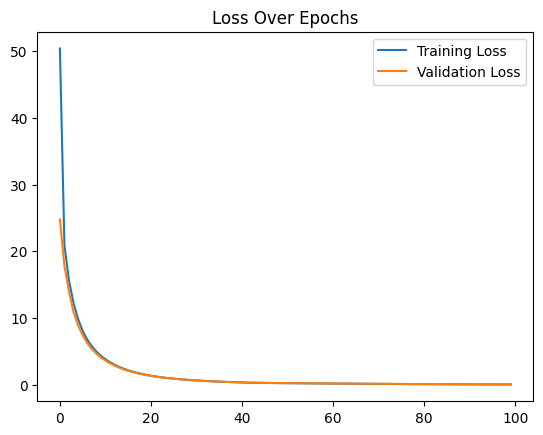

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold:  0.1522315
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  1, 337]))
len(test_loss) = len(test_data)?: (338, 338)


In [219]:
#Boundary condition: primordial run

# The last element contains the labels
labels = anomaly_list
# The other data points are the data
data = X_input

#new variables for the moving window problem
test_loss = []
preds_list = []
val_preds_list = []
threshold_list = []
k_list = []
beta_list = []
batch_limits = []

normal_train_data = np.empty((0, input_dim), dtype=np.float32)  # Empty array with correct shape
anomalous_train_data = np.empty((0, input_dim), dtype=np.float32)
normal_val_data = np.empty((0, input_dim), dtype=np.float32)
anomalous_val_data = np.empty((0, input_dim), dtype=np.float32)


test_cycle_normalized = np.empty((1, input_dim), dtype=np.float32)
test_cycle = np.empty((1, input_dim), dtype=np.float32)
good_cycles = np.empty((1,input_dim), dtype=np.float32)







# Split the data and labels
train_data = data[index_mar:index_apr].astype(np.float32)
val_data = data[index_apr:index_mai]
val_timestamps = timestamps[index_apr:index_mai]
test_data = data[index_mai:last_test_index].astype(np.float32) # Assuring we only test 1 week at a time
test_timestamps = timestamps[index_mai:last_test_index]
batch_limits.append([index_mai, last_test_index])


train_labels = labels[index_mar:index_apr]
train_len = len(train_labels)
val_labels = labels[index_apr:index_mai]
test_labels = labels[index_mai:last_test_index] # Assuring we only test 1 week at a time

#Pass to boolean
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Separate into normal and anomalous data
for i in range(len(train_labels)):
    if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :]), axis=0)
    else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :]), axis=0)

for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data = np.concatenate((normal_val_data, val_data[i:i+1, :]), axis=0)
    else:
        anomalous_val_data = np.concatenate((anomalous_val_data, val_data[i:i+1, :]), axis=0)


normal_train_data_normalized = np.zeros_like(normal_train_data)
test_data_normalized = np.zeros_like(test_data)
val_data_normalized = np.zeros_like(val_data)
normal_val_data_normalized = np.empty((0, input_dim), dtype=np.float32)
anomalous_val_data_normalized = np.empty((0, input_dim), dtype=np.float32)



scaler = MinMaxScaler()
normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 2 (columns 7-13)
normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 3 (columns 14-20)
normal_train_data_normalized[:, 14:21] = scaler.fit_transform(normal_train_data[:, 14:21].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,14:21] = scaler.transform(test_data[:, 14:21].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,14:21] = scaler.transform(val_data[:, 14:21].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 4 (columns 21-27)
normal_train_data_normalized[:, 21:28] = scaler.fit_transform(normal_train_data[:, 21:28].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,21:28] = scaler.transform(test_data[:, 21:28].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,21:28] = scaler.transform(val_data[:, 21:28].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 5 (columns 28-34)
normal_train_data_normalized[:, 28:35] = scaler.fit_transform(normal_train_data[:, 28:35].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,28:35] = scaler.transform(test_data[:, 28:35].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,28:35] = scaler.transform(val_data[:, 28:35].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 6 (columns 35-41)
normal_train_data_normalized[:, 35:42] = scaler.fit_transform(normal_train_data[:, 35:42].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,35:42] = scaler.transform(test_data[:, 35:42].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,35:42] = scaler.transform(val_data[:, 35:42].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 6 (columns 42-48)
normal_train_data_normalized[:, 42:49] = scaler.fit_transform(normal_train_data[:, 42:49].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,42:49] = scaler.transform(test_data[:, 42:49].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,42:49] = scaler.transform(val_data[:, 42:49].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 7 (columns 49-55)
normal_train_data_normalized[:, 49:56] = scaler.fit_transform(normal_train_data[:, 49:56].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,49:56] = scaler.transform(test_data[:, 49:56].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,49:56] = scaler.transform(val_data[:, 49:56].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 8 (columns 56-62)
normal_train_data_normalized[:, 56:63] = scaler.fit_transform(normal_train_data[:, 56:63].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,56:63] = scaler.transform(test_data[:, 56:63].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,56:63] = scaler.transform(val_data[:, 56:63].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 9
normal_train_data_normalized[:, 63:70] = scaler.fit_transform(normal_train_data[:, 63:70].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,63:70] = scaler.transform(test_data[:, 63:70].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,63:70] = scaler.transform(val_data[:, 63:70].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 10
normal_train_data_normalized[:, 70:77] = scaler.fit_transform(normal_train_data[:, 70:77].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,70:77] = scaler.transform(test_data[:, 70:77].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,70:77] = scaler.transform(val_data[:, 70:77].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 11
normal_train_data_normalized[:, 77:84] = scaler.fit_transform(normal_train_data[:, 77:84].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,77:84] = scaler.transform(test_data[:, 77:84].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,77:84] = scaler.transform(val_data[:, 77:84].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 12
normal_train_data_normalized[:, 84:91] = scaler.fit_transform(normal_train_data[:, 84:91].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,84:91] = scaler.transform(test_data[:, 84:91].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,84:91] = scaler.transform(val_data[:, 84:91].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 13
normal_train_data_normalized[:, 91:98] = scaler.fit_transform(normal_train_data[:, 91:98].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,91:98] = scaler.transform(test_data[:, 91:98].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,91:98] = scaler.transform(val_data[:, 91:98].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

'''# Fit and transform sensor 14
normal_train_data_normalized[:, 98:105] = scaler.fit_transform(normal_train_data[:, 98:105].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,98:105] = scaler.transform(test_data[:, 98:105].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,98:105] = scaler.transform(val_data[:, 98:105].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)'''


# Fit and transform Trun (column 14)
normal_train_data_normalized[:, 98] = scaler.fit_transform(normal_train_data[:, 98].reshape(-1, 1)).flatten()
test_data_normalized[:, 98] = scaler.transform(test_data[:, 98].reshape(-1, 1)).flatten()
val_data_normalized[:, 98] = scaler.transform(val_data[:, 98].reshape(-1, 1)).flatten()

# Fit and transform Tidle (column 15)
normal_train_data_normalized[:, 99] = scaler.fit_transform(normal_train_data[:, 99].reshape(-1, 1)).flatten()
test_data_normalized[:, 99] = scaler.transform(test_data[:, 99].reshape(-1, 1)).flatten()
val_data_normalized[:, 99] = scaler.transform(val_data[:, 99].reshape(-1, 1)).flatten()


#Separate into normal and anomalous data
for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)

if timestamps[3679] in val_timestamps:
    shap_test_data_1 = val_data_normalized[np.where(val_timestamps == timestamps[3679])[0][0]:np.where(val_timestamps == timestamps[3679])[0][0]+1]



# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_normalized,  # Input and target are the same for autoencoders
    y=normal_train_data_normalized,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30,
    validation_data=(normal_val_data_normalized, normal_val_data_normalized),
    verbose=1
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_val = autoencoder.predict(val_data_normalized)
val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

reconstructions_val_normal = autoencoder.predict(normal_val_data_normalized)
val_loss_normal = tf.keras.losses.mae(reconstructions_val_normal, normal_val_data_normalized)

Q1_aux = np.percentile(val_loss_normal, 25)
Q3_aux = np.percentile(val_loss_normal, 75)
IQR_aux = Q3_aux - Q1_aux
k_aux = 4
val_threshold = k_aux * IQR_aux + Q3_aux
filtered_val_loss_normal = val_loss_normal[val_loss_normal < val_threshold]

if 1 in val_labels:
    val_mask = (val_loss <= val_threshold) | (val_labels == 1) #Remove "normal" dat beyond a certain threshold

    filtered_val_loss = val_loss[val_mask]
    filtered_val_labels = val_labels[val_mask]

    y_true = (np.array(filtered_val_labels) != 0).astype(int)
    scores = np.array(filtered_val_loss)

    # 1. Calculate precision, recall, and thresholds.
    precision, recall, thresholds = precision_recall_curve_exclusive(y_true, scores)

    # Note: precision and recall arrays have one extra element compared to thresholds.
    # We'll compute F1 scores for the thresholds only.
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
    # 2. Identify the best threshold (maximizing F1 score)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
##############################################################REPLACE TYKEY'S FENCES WITH 99-PERCENTILE
    # Compute quartiles and IQR
    Q1 = np.percentile(filtered_val_loss_normal, 25)
    Q3 = np.percentile(filtered_val_loss_normal, 75)
    IQR = Q3 - Q1
    # Compute k
    k = (best_threshold - Q3) / IQR
    
else:
    best_threshold = np.percentile(val_loss, 99) #REPLACE max(val_loss) by 99-percentile

    # Compute quartiles and IQR
    Q1 = np.percentile(filtered_val_loss_normal, 25)
    Q3 = np.percentile(filtered_val_loss_normal, 75)
    IQR = Q3 - Q1
    # Compute k
    k = (best_threshold - Q3) / IQR
    #beta = best_threshold/np.percentile(val_loss, 99)

threshold_list.append(best_threshold)
#beta_list.append(beta)
k_list.append(k)
print("Threshold: ", best_threshold)



# Calculate the reconstruction loss for the anomalous test data
reconstructions_test = autoencoder.predict(test_data_normalized)
val_pred = predict(autoencoder, val_data_normalized, best_threshold).numpy()
pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy()
preds_list = np.concatenate((preds_list, pred_aux), axis=0)
'''pred_val_aux = val_labels #predict(autoencoder, normal_val_data_normalized, best_threshold)
val_preds_list = np.concatenate((val_preds_list, pred_val_aux), axis=0)'''
print("pred_aux:", np.unique(pred_aux, return_counts=True))

test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())
print(f"len(test_loss) = len(test_data)?: {len(test_loss), test_data.shape[0]}")


#### Plotting the threshold with the test sets

In [220]:
normal_test_data_normalized = np.empty((0, input_dim), dtype=np.float32)  # Empty array with correct shape
anomalous_test_data_normalized = np.empty((0, input_dim), dtype=np.float32)
for i in range(len(test_labels)):
    if test_labels[i] == 0:
        normal_test_data_normalized = np.concatenate((normal_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_test_data_normalized = np.concatenate((anomalous_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
reconstructions_test_normal = autoencoder.predict(normal_test_data_normalized)
normal_test_loss = tf.keras.losses.mae(reconstructions_test_normal, normal_test_data_normalized)

try:
    reconstructions_test_anomalous = autoencoder.predict(anomalous_test_data_normalized)
    anomalous_test_loss = tf.keras.losses.mae(reconstructions_test_anomalous, anomalous_test_data_normalized)

    # Plot both losses on the same histogram
    plt.hist(normal_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='blue', label='Normal')
    plt.hist(anomalous_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='red', label='Anomalous')

    plt.xlabel("Reconstruction Loss")
    plt.ylabel("Number of Examples")
    plt.legend(loc='upper right')
    plt.title("Reconstruction Loss for Normal and Anomalous Data")
    plt.axvline(x=best_threshold, color='black', linestyle='--')
    #plt.ylim((0, 40))
    plt.show()
except:
    print("No anomalies in the test set")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
No anomalies in the test set


c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


#### Moving window

Cycle: 1/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1136, 100)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
Point 2/16. k = 3.9746241569519043


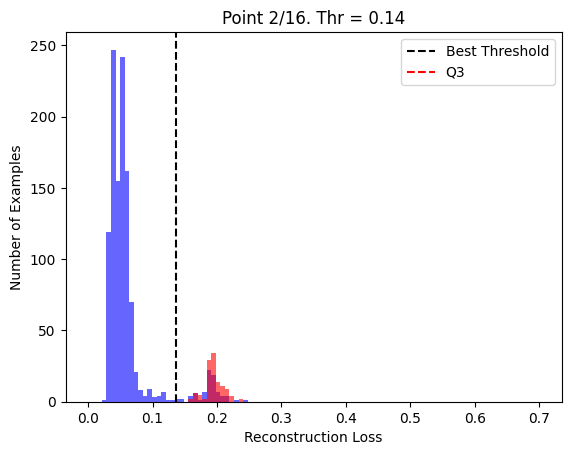

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
pred_aux: (array([False,  True]), array([ 56, 228]))
Threshold:  0.13635485
len(test_loss) = len(test_data)?: (284, 284)
Cycle: 2/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1117, 100)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 3/16. k = 3.871302843093872


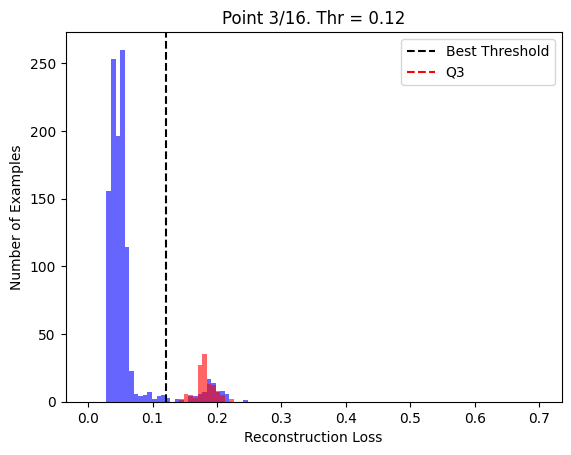

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([118, 417]))
Threshold:  0.12153867
len(test_loss) = len(test_data)?: (535, 535)
Cycle: 3/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1439, 100)
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pred_aux: (array([False,  True]), array([  8, 303]))
Threshold:  0.10633014
len(test_loss) = len(test_data)?: (311, 311)
Cycle: 4/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1539, 100)
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pred_aux: (array([False,  True]), array([117, 352]))
Threshold:  0.100784376
len(test_loss) = len(test_data)?: (469, 469)
Cycle: 5/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1622, 100)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


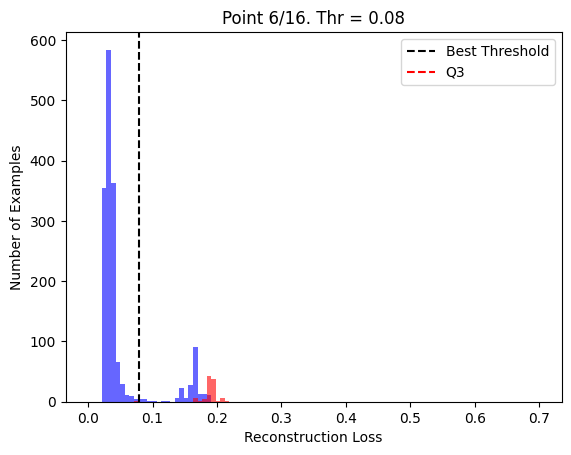

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([199, 250]))
Threshold:  0.07871738
len(test_loss) = len(test_data)?: (449, 449)
Cycle: 6/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1617, 100)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 7/16. k = 3.879002809524536


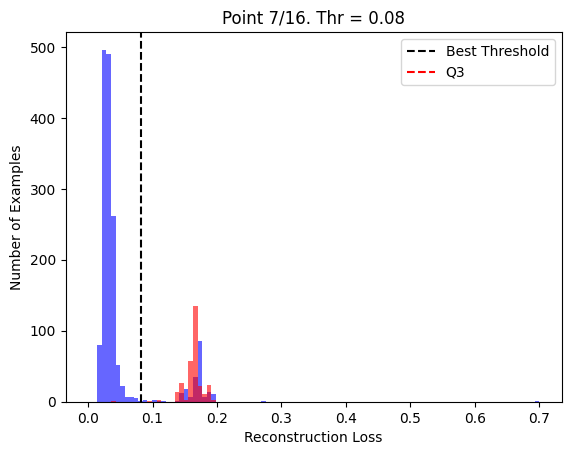

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pred_aux: (array([False,  True]), array([  1, 538]))
Threshold:  0.081350215
len(test_loss) = len(test_data)?: (539, 539)
Cycle: 7/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1733, 100)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Point 8/16. k = 3.9578468799591064


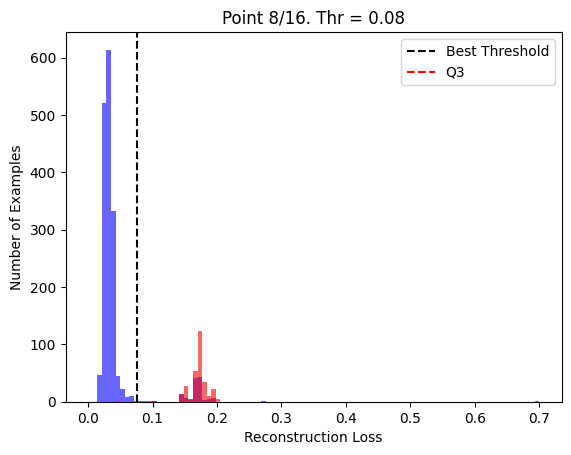

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pred_aux: (array([False,  True]), array([  4, 312]))
Threshold:  0.07557766
len(test_loss) = len(test_data)?: (316, 316)
Cycle: 8/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1605, 100)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
Point 9/16. k = 3.893909454345703


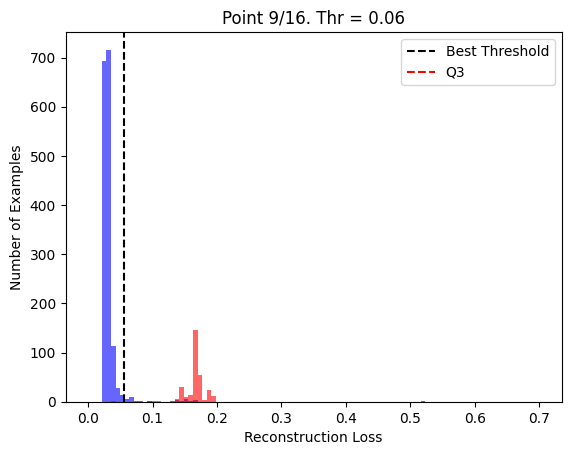

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  4, 386]))
Threshold:  0.05507285
len(test_loss) = len(test_data)?: (390, 390)
Cycle: 9/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1648, 100)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 10/16. k = 3.8917531967163086


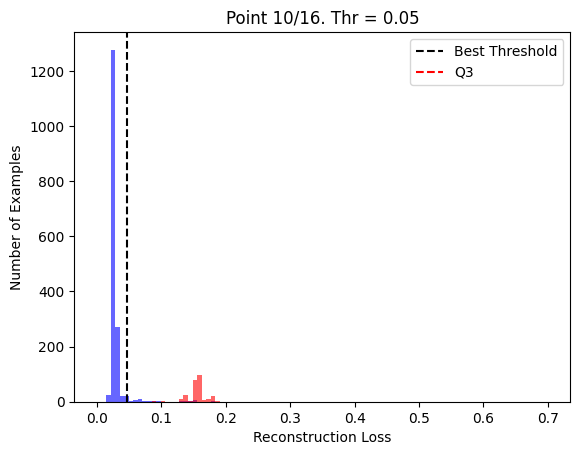

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pred_aux: (array([False,  True]), array([ 33, 417]))
Threshold:  0.04596704
len(test_loss) = len(test_data)?: (450, 450)
Cycle: 10/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1850, 100)
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
pred_aux: (array([False,  True]), array([ 42, 478]))
Threshold:  0.048500024
len(test_loss) = len(test_data)?: (520, 520)
Cycle: 11/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1882, 100)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Point 12/16. k = 3.675950527191162


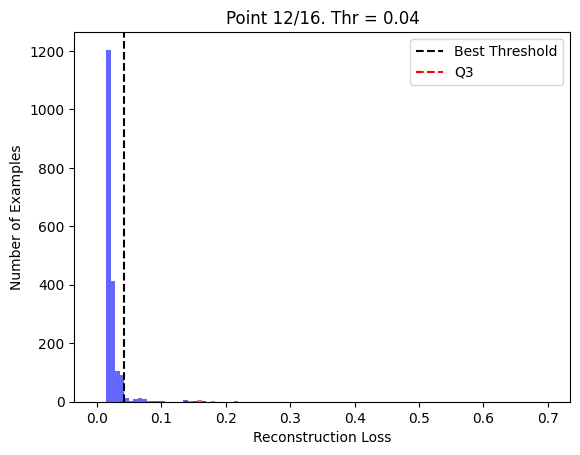

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pred_aux: (array([False,  True]), array([  9, 441]))
Threshold:  0.042029634
len(test_loss) = len(test_data)?: (450, 450)
Cycle: 12/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1909, 100)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Point 13/16. k = 3.9648067951202393


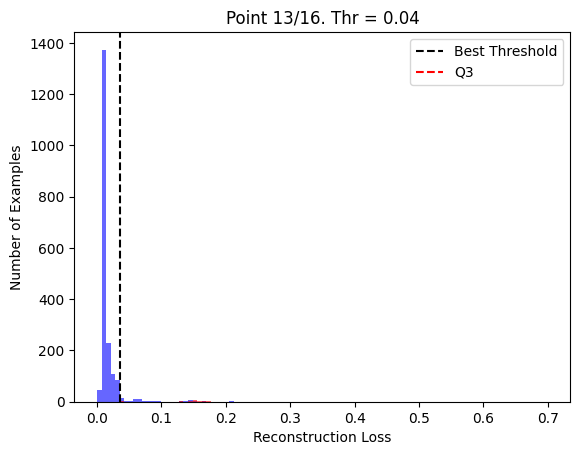

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pred_aux: (array([False,  True]), array([ 13, 403]))
Threshold:  0.035984844
len(test_loss) = len(test_data)?: (416, 416)
Cycle: 13/10
normal val data shape: (1121, 100)
normal val data normalized shape: (2030, 100)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Point 14/16. k = 3.7926928997039795


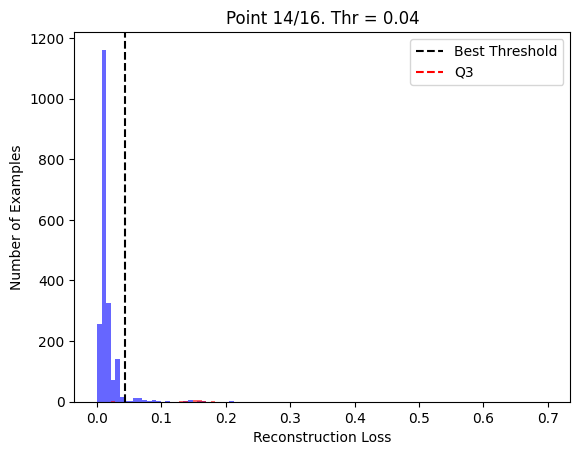

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  6, 362]))
Threshold:  0.04307226
len(test_loss) = len(test_data)?: (368, 368)
Cycle: 14/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1931, 100)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
Point 15/16. k = 3.999612331390381


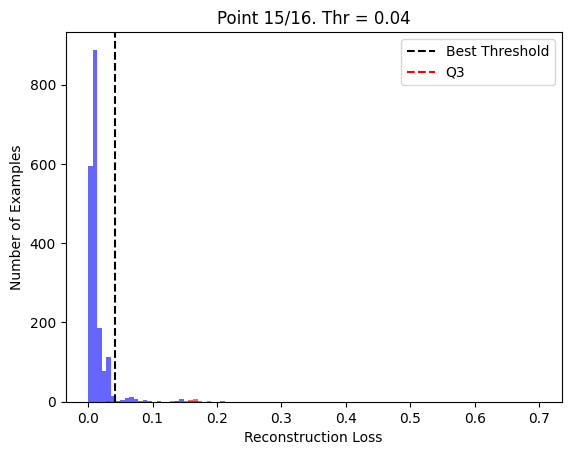

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
pred_aux: (array([False,  True]), array([  4, 485]))
Threshold:  0.04160713
len(test_loss) = len(test_data)?: (489, 489)
Cycle: 15/10
normal val data shape: (1121, 100)
normal val data normalized shape: (2004, 100)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Point 16/16. k = 3.99656081199646


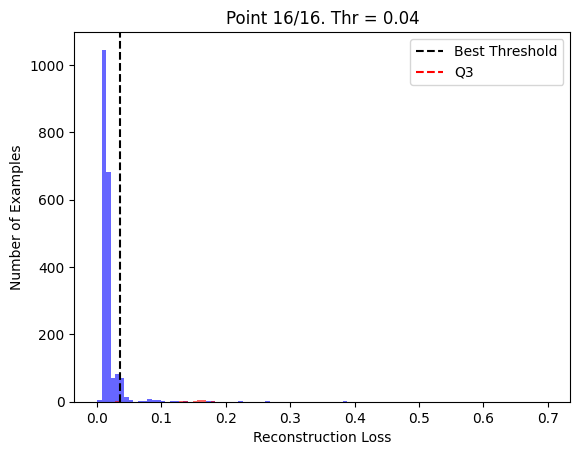

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
pred_aux: (array([False,  True]), array([ 25, 418]))
Threshold:  0.036544003
len(test_loss) = len(test_data)?: (443, 443)
Cycle: 16/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1894, 100)
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
pred_aux: (array([False,  True]), array([ 20, 429]))
Threshold:  0.032926176
len(test_loss) = len(test_data)?: (449, 449)
Cycle: 17/10
normal val data shape: (1121, 100)
normal val data normalized shape: (1934, 100)
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
pred_aux: (array([False,  True]), array([  7, 210]))
Threshold:  0.03449221


In [221]:
n = 1
break_flag = False

#Computing number of cycles
for j in range(100):
    try:
        next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=j*time_delta))
        num_cycles = j+1
    except:
        break


while True:
    try:
        first_val_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_apr]+pd.Timedelta(days=n*time_delta))
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=n*time_delta))
        last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=(n+1)*time_delta))
            

        print(f"Cycle: {n}/{num_cycles+1}")
        test_data = data[last_test_index:last_test_index_2]
        test_timestamps = timestamps[last_test_index:last_test_index_2]
        test_labels = labels[last_test_index:last_test_index_2]
        
        batch_limits.append([last_test_index, last_test_index_2])


    except:
        first_val_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_apr]+pd.Timedelta(days=n*time_delta))
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=n*time_delta))
        print(f"Cycle: {n}/{num_cycles+1}")
        test_data = data[last_test_index:]
        test_labels = labels[last_test_index:]
        test_timestamps = timestamps[last_test_index:]
        batch_limits.append([last_test_index, X_input.shape[0]])

        break_flag = True


    val_data = data[first_val_index:last_test_index]
    val_labels = labels[first_val_index:last_test_index]
    val_timestamps = timestamps[first_val_index:last_test_index]

    if 1 in val_labels: #Update training set
        aux_train_indices = [i for i in range(first_val_index) if labels[i] == 0][-train_len:]  # Get the last train_len normal indices
        normal_train_data = data[aux_train_indices]

    normal_train_data_normalized = np.zeros_like(normal_train_data)
    test_data_normalized = np.zeros_like(test_data)
    val_data_normalized = np.zeros_like(val_data)
    normal_val_data_normalized = np.empty((0, input_dim), dtype=np.float32)
    anomalous_val_data_normalized = np.empty((0, input_dim), dtype=np.float32)


    scaler = MinMaxScaler()
    normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 2 (columns 7-13)
    normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 3 (columns 14-20)
    normal_train_data_normalized[:, 14:21] = scaler.fit_transform(normal_train_data[:, 14:21].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,14:21] = scaler.transform(test_data[:, 14:21].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,14:21] = scaler.transform(val_data[:, 14:21].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 4 (columns 21-27)
    normal_train_data_normalized[:, 21:28] = scaler.fit_transform(normal_train_data[:, 21:28].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,21:28] = scaler.transform(test_data[:, 21:28].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,21:28] = scaler.transform(val_data[:, 21:28].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 5 (columns 28-34)
    normal_train_data_normalized[:, 28:35] = scaler.fit_transform(normal_train_data[:, 28:35].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,28:35] = scaler.transform(test_data[:, 28:35].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,28:35] = scaler.transform(val_data[:, 28:35].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 6 (columns 35-41)
    normal_train_data_normalized[:, 35:42] = scaler.fit_transform(normal_train_data[:, 35:42].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,35:42] = scaler.transform(test_data[:, 35:42].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,35:42] = scaler.transform(val_data[:, 35:42].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 6 (columns 42-48)
    normal_train_data_normalized[:, 42:49] = scaler.fit_transform(normal_train_data[:, 42:49].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,42:49] = scaler.transform(test_data[:, 42:49].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,42:49] = scaler.transform(val_data[:, 42:49].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 7 (columns 49-55)
    normal_train_data_normalized[:, 49:56] = scaler.fit_transform(normal_train_data[:, 49:56].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,49:56] = scaler.transform(test_data[:, 49:56].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,49:56] = scaler.transform(val_data[:, 49:56].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 8 (columns 56-62)
    normal_train_data_normalized[:, 56:63] = scaler.fit_transform(normal_train_data[:, 56:63].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,56:63] = scaler.transform(test_data[:, 56:63].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,56:63] = scaler.transform(val_data[:, 56:63].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 9
    normal_train_data_normalized[:, 63:70] = scaler.fit_transform(normal_train_data[:, 63:70].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,63:70] = scaler.transform(test_data[:, 63:70].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,63:70] = scaler.transform(val_data[:, 63:70].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 10
    normal_train_data_normalized[:, 70:77] = scaler.fit_transform(normal_train_data[:, 70:77].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,70:77] = scaler.transform(test_data[:, 70:77].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,70:77] = scaler.transform(val_data[:, 70:77].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 11
    normal_train_data_normalized[:, 77:84] = scaler.fit_transform(normal_train_data[:, 77:84].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,77:84] = scaler.transform(test_data[:, 77:84].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,77:84] = scaler.transform(val_data[:, 77:84].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 12
    normal_train_data_normalized[:, 84:91] = scaler.fit_transform(normal_train_data[:, 84:91].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,84:91] = scaler.transform(test_data[:, 84:91].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,84:91] = scaler.transform(val_data[:, 84:91].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 13
    normal_train_data_normalized[:, 91:98] = scaler.fit_transform(normal_train_data[:, 91:98].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,91:98] = scaler.transform(test_data[:, 91:98].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,91:98] = scaler.transform(val_data[:, 91:98].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    '''    # Fit and transform sensor 14
    normal_train_data_normalized[:, 98:105] = scaler.fit_transform(normal_train_data[:, 98:105].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,98:105] = scaler.transform(test_data[:, 98:105].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,98:105] = scaler.transform(val_data[:, 98:105].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)'''

    # Fit and transform Trun (column 14)
    normal_train_data_normalized[:, 98] = scaler.fit_transform(normal_train_data[:, 98].reshape(-1, 1)).flatten()
    test_data_normalized[:, 98] = scaler.transform(test_data[:, 98].reshape(-1, 1)).flatten()
    val_data_normalized[:, 98] = scaler.transform(val_data[:, 98].reshape(-1, 1)).flatten()

    # Fit and transform Tidle (column 15)
    normal_train_data_normalized[:, 99] = scaler.fit_transform(normal_train_data[:, 99].reshape(-1, 1)).flatten()
    test_data_normalized[:, 99] = scaler.transform(test_data[:, 99].reshape(-1, 1)).flatten()
    val_data_normalized[:, 99] = scaler.transform(val_data[:, 99].reshape(-1, 1)).flatten()

    if n == 2:
        shap_test_data = test_data_normalized
        shap_test_labels = test_labels 

    #Separate into normal and anomalous data
    for i in range(len(val_labels)):
        if val_labels[i] == 0:
            normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
        else:
            anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)

    print(f"normal val data shape: {np.shape(normal_val_data)}")
    print(f"normal val data normalized shape: {np.shape(normal_val_data_normalized)}")

    if timestamps[5667] in test_timestamps:
        shap_test_data_2 = test_data_normalized[np.where(test_timestamps == timestamps[5667])[0][0]:np.where(test_timestamps == timestamps[5667])[0][0]+1]

    if timestamps[6069] in test_timestamps:
        shap_test_data_3 = test_data_normalized[np.where(test_timestamps == timestamps[6069])[0][0]:np.where(test_timestamps == timestamps[6069])[0][0]+1]

    if timestamps[8597] in test_timestamps:
        shap_test_data_4 = test_data_normalized[np.where(test_timestamps == timestamps[8597])[0][0]:np.where(test_timestamps == timestamps[8597])[0][0]+1]

    if 1 in val_labels:
        reconstructions_val_anomalous = autoencoder.predict(anomalous_val_data_normalized)
        val_loss_anomalous = tf.keras.losses.mae(reconstructions_val_anomalous, anomalous_val_data_normalized)
        # Compile the model with the custom loss
        autoencoder.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
        )

        # Train the model
        history = autoencoder.fit(
            x=normal_train_data_normalized,  # Input and target are the same for autoencoders
            y=normal_train_data_normalized,  # Input and target are the same for autoencoders
            epochs=100,
            batch_size=30,
            validation_data=(normal_val_data_normalized, normal_val_data_normalized),
            verbose=0
        )

    ## Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
    reconstructions_val = autoencoder.predict(val_data_normalized)
    val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

    reconstructions_val_normal = autoencoder.predict(normal_val_data_normalized)
    val_loss_normal = tf.keras.losses.mae(reconstructions_val_normal, normal_val_data_normalized)

    Q1_aux = np.percentile(val_loss_normal, 25)
    Q3_aux = np.percentile(val_loss_normal, 75)
    IQR_aux = Q3_aux - Q1_aux
    val_threshold = k_aux * IQR_aux + Q3_aux
    filtered_val_loss_normal = val_loss_normal[val_loss_normal < val_threshold]

    if 1 in val_labels:
        val_mask = (val_loss <= val_threshold) | (val_labels == 1) #Remove "normal" dat beyond a certain threshold

        filtered_val_loss = val_loss[val_mask]
        filtered_val_labels = val_labels[val_mask]

        y_true = (np.array(filtered_val_labels) != 0).astype(int)
        scores = np.array(filtered_val_loss)

        # 1. Calculate precision, recall, and thresholds.
        precision, recall, thresholds = precision_recall_curve_exclusive(y_true, scores)

        # Note: precision and recall arrays have one extra element compared to thresholds.
        # We'll compute F1 scores for the thresholds only.
        # F1 = 2 * (precision * recall) / (precision + recall)
        f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
        # 2. Identify the best threshold (maximizing F1 score)
        best_idx = np.argmax(f1_scores)
        best_threshold = min(np.percentile(val_loss_normal, 99), thresholds[best_idx])

        # Compute quartiles and IQR
        Q1 = np.percentile(val_loss_normal, 25)
        Q3 = np.percentile(val_loss_normal, 75)
        IQR = Q3 - Q1
        # Compute k
        k = (best_threshold - Q3) / IQR
        print(f"Point {n+1}/16. k = {k}")

        plt.hist(val_loss_normal, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='blue', label='Normal')
        plt.hist(val_loss_anomalous, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='red', label='Normal')

        plt.xlabel("Reconstruction Loss")
        plt.ylabel("Number of Examples")
        plt.legend(loc='upper right', handles=[
            plt.Line2D([0], [0], color='black', linestyle='--', label='Best Threshold'),
            plt.Line2D([0], [0], color='red', linestyle='--', label='Q3')
        ])
        plt.title(f"Point {n+1}/16. Thr = {best_threshold:.2f}")
        plt.axvline(x=best_threshold, color='black', linestyle='--')
        #plt.axvline(x=Q3, color='red', linestyle='--')
        #plt.ylim((0, 40))
        plt.show()
        #beta = best_threshold/np.percentile(val_loss, 99)
        


        '''######################################
        plt.figure(figsize=(7, 3))

        plt.subplot(1, 2, 1)
        plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve for Cycle {n+1}/{num_cycles}")
        plt.legend()

        # Plot F1 Score vs. Threshold
        plt.subplot(1, 2, 2)
        plt.plot(thresholds, f1_scores, marker='.', label="F1 Score")
        plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Best Threshold: {best_threshold:.4f}")
        plt.xlabel("Threshold")
        plt.ylabel("F1 Score")
        plt.title(f"F1 Score vs. Threshold for Cycle {n+1}/{num_cycles}")
        plt.legend()

        plt.tight_layout()
        plt.show()
        ######################################'''
    #Comment out the 'else' if what you want to keep constant is the THRESHOLD and NOT the value of k
    else:
        # Compute quartiles and IQR
        Q1 = np.percentile(filtered_val_loss_normal, 25)
        Q3 = np.percentile(filtered_val_loss_normal, 75)
        IQR = Q3 - Q1
        best_threshold = Q3 + k * IQR
        #best_threshold = beta*np.percentile(val_loss, 99)
    
    k_list.append(k)
    #beta_list.append(beta)
    threshold_list.append(best_threshold)
    
    
    # Calculate the reconstruction loss for the anomalous test data
    pred_val_aux = pred_aux #former test set is now validation set. Use former cycle's test labels as validation labels in this cycle
    reconstructions_test = autoencoder.predict(test_data_normalized)
    pred_aux = []
    pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy().astype(bool)
    preds_list = np.concatenate((preds_list, pred_aux), axis=0)
    print("pred_aux:", np.unique(pred_aux, return_counts=True))
    print("Threshold: ", best_threshold)

    test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())
    if break_flag==True:
        break
    print(f"len(test_loss) = len(test_data)?: {len(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy()), test_data.shape[0]}")
    n += 1

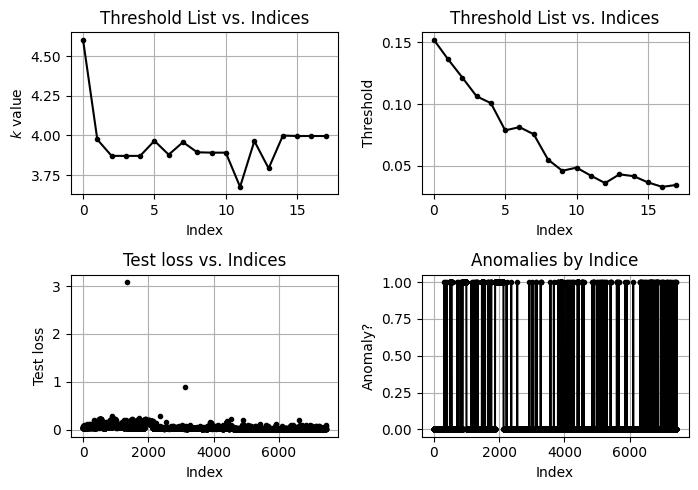

In [222]:
plt.figure(figsize=(7, 5))

# Plot k_list against the respective indices
plt.subplot(2, 2, 1)
plt.plot(k_list[:], marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('$k$ value')
plt.title('Threshold List vs. Indices')
plt.grid(True)

# Plot threshold_list against the respective indices
plt.subplot(2, 2, 2)
plt.plot(threshold_list[:], marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Threshold')
plt.title('Threshold List vs. Indices')
plt.grid(True)

# Plot test_loss against the respective indices
plt.subplot(2, 2, 3)
plt.plot(test_loss, marker='.', linestyle=' ', color='black')
plt.xlabel('Index')
plt.ylabel('Test loss')
plt.title('Test loss vs. Indices')
plt.grid(True)

# Convert boolean values: True -> 0, False -> 1
plot_preds_list = [0 if pred else 1 for pred in preds_list]

# Plot the converted preds_list
plt.subplot(2, 2, 4)
plt.plot(plot_preds_list, marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Anomalies by Indice')
plt.grid(True)

plt.tight_layout()
plt.show()

## Metrics and Confusion Matrix

In [223]:
len(data[next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=time_delta)):])


7095

In [224]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
all_predictions = []
conf_matrix_list = []

# Reshape test_loss to a 2D array and fit and transform it
test_loss_normalized = scaler.fit_transform(np.array(test_loss).reshape(-1, 1)).flatten()
aux_index = index_mai
anomaly_list_binary = np.array(anomaly_list[aux_index:], dtype=int)

def compute_f1_for_threshold(anomaly_list_binary, test_loss_normalized, threshold):
    predicted_anomalies = (tf.convert_to_tensor(test_loss_normalized) >= threshold).numpy().astype(int)
    return f1_score(anomaly_list_binary, predicted_anomalies), predicted_anomalies

for i in range(len(threshold_list)):
    start_idx = batch_limits[i][0] - batch_limits[0][0]  # Start index of the segment
    end_idx = batch_limits[i][1] - batch_limits[0][0]  # End index
    # Function to compute F1-score for a given threshold
    # Search for the best threshold
    thresholds = np.linspace(0, 1, 10000)
    best_threshold = threshold_list[i]
    best_f1, best_predictions = compute_f1_for_threshold(anomaly_list_binary[start_idx:end_idx], test_loss[start_idx:end_idx], best_threshold)
    # Compute confusion matrix
    all_predictions = np.concatenate([all_predictions, best_predictions])
    conf_matrix_list.append(confusion_matrix(anomaly_list_binary[start_idx:end_idx], best_predictions, labels=[0, 1]))

Segment 0: start=0, end=338, threshold=0.15223149955272675
Segment 1: start=338, end=622, threshold=0.13635484874248505
Segment 2: start=622, end=1157, threshold=0.1215386688709259
Segment 3: start=1157, end=1468, threshold=0.10633014142513275
Segment 4: start=1468, end=1937, threshold=0.10078437626361847
Segment 5: start=1937, end=2386, threshold=0.07871738076210022
Segment 6: start=2386, end=2925, threshold=0.08135021477937698
Segment 7: start=2925, end=3241, threshold=0.07557766139507294
Segment 8: start=3241, end=3631, threshold=0.0550728514790535
Segment 9: start=3631, end=4081, threshold=0.045967038720846176
Segment 10: start=4081, end=4601, threshold=0.048500023782253265
Segment 11: start=4601, end=5051, threshold=0.04202963411808014
Segment 12: start=5051, end=5467, threshold=0.03598484396934509
Segment 13: start=5467, end=5835, threshold=0.04307226091623306
Segment 14: start=5835, end=6324, threshold=0.04160713031888008
Segment 15: start=6324, end=6767, threshold=0.03654400259

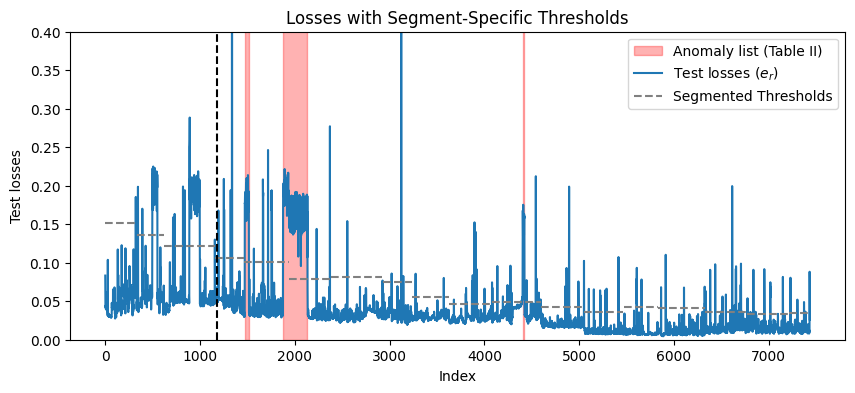

In [225]:
# Plot test losses
aux_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai])
plt.figure(figsize=(10, 4))
plt.fill_between(range(len(anomaly_list[aux_index:])), 0, 1, where=np.array(anomaly_list[aux_index:]) == 1, 
                 color='red', alpha=0.3, label='Anomaly list (Table II)')
plt.plot(test_loss, label="Test losses ($e_r$)", linestyle='-')

# Plot segmented threshold lines
for i in range(len(threshold_list)):
    start_idx = batch_limits[i][0] - batch_limits[0][0]  # Start index of the segment
    end_idx = batch_limits[i][1] - batch_limits[0][0]  # End index

    print(f"Segment {i}: start={start_idx}, end={end_idx}, threshold={threshold_list[i]}")
    
    # Ensure non-overlapping segments
    if start_idx < end_idx:
        plt.plot(range(start_idx, end_idx), 
                 threshold_list[i]*np.ones(end_idx - start_idx), 
                 linestyle='--', color='gray')

# Add legend for threshold
custom_legend = [Line2D([0], [0], color='gray', linestyle='--', label="Segmented Thresholds")]
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_legend, loc='upper right')

# Formatting
plt.title('Losses with Segment-Specific Thresholds')
plt.xlabel('Index')
plt.ylabel('Test losses')
plt.ylim((0, 0.4))
plt.axvline(x=1180, color='black', linestyle='--', label='Start of April')
plt.show()

Confusion Matrix = 
| True Negatives |     False Positives |
| -------------  |  --------------- |
| **False Negatives**   |  **True Positives** |

In [226]:
cm = np.sum(conf_matrix_list, axis=0)
TN, FP, FN, TP = cm.ravel()

# Computing metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = (TP / (TP + FP)) if (TP + FP) > 0 else 0
recall = (TP / (TP + FN)) if (TP + FN) > 0 else 0
f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

# Display results
print("Confusion Matrix with custom thresholds:")
print(f"{cm}\n")

print(f"Accuracy = {100*accuracy:.2f}%")
print(f"Precision = {100*precision:.2f}%")
print(f"Recall = {100*recall:.2f}%")
print(f"F1 Score = {100*f1_score:.2f}%")

Confusion Matrix with custom thresholds:
[[6764  352]
 [   2  315]]

Accuracy = 95.24%
Precision = 47.23%
Recall = 99.37%
F1 Score = 64.02%


k_aux = 5
Confusion Matrix with custom thresholds:
[[7832  146]
 [   8  686]]

Accuracy = 98.22%
Precision = 82.45%
Recall = 98.85%
F1 Score = 89.91%

k_aux=9
Confusion Matrix with custom thresholds:
[[7881   97]
 [  38  656]]

Accuracy = 98.44%
Precision = 87.12%
Recall = 94.52%
F1 Score = 90.67%

OG
Confusion Matrix with custom thresholds:
[[7894   84]
 [  49  645]]

Accuracy = 98.47%
Precision = 88.48%
Recall = 92.94%
F1 Score = 90.65%

Confusion Matrix with custom thresholds:
[[7931   47]
 [  47  647]]

Accuracy = 98.92%
Precision = 93.23%
Recall = 93.23%
F1 Score = 93.23%

In [227]:
np.shape(all_predictions)

(7433,)

In [228]:
np.shape(timestamps[index_apr:])

(8672,)

In [229]:
np.unique(all_predictions, return_counts=True)

(array([0., 1.]), array([6766,  667]))

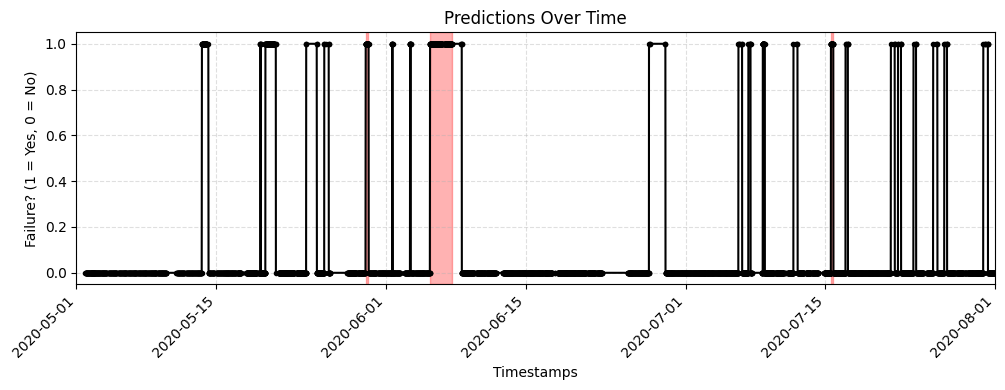

In [230]:
plt.figure(figsize=(10, 4))

# Convert boolean values: True -> 1, False -> 0 for plotting
plot_predictions = [1 if pred else 0 for pred in all_predictions]


def generate_failure_flags(predictions):
    failure_flags = [0] * len(predictions)
    in_failure = False
    i = 0
    while i < len(predictions) - 1:
        if not in_failure:
            # Check for two consecutive anomalies to start a failure
            if predictions[i] == 1 and predictions[i+1] == 1:
                in_failure = True
                failure_flags[i] = 1
                failure_flags[i+1] = 1
                i += 2
                continue
        else:
            failure_flags[i] = 1
            # Check for two consecutive normals to end a failure
            if predictions[i] == 0 and predictions[i+1] == 0:
                in_failure = False
            failure_flags[i+1] = 1
        i += 1

    # Edge case: if in_failure was still True at the end, fill last value
    if in_failure and i == len(predictions) - 1:
        failure_flags[-1] = 1

    return failure_flags

failure_predictions = generate_failure_flags(plot_predictions)









# Plot predictions against timestamps
plt.plot(timestamps[index_mai:], failure_predictions, marker='.', linestyle='-', color='black')

highlight_ranges = [
    ("2020-04-18 00:00", "2020-04-18 23:59"),
    ("2020-05-29 23:30", "2020-05-30 06:00"),
    ("2020-06-05 10:00", "2020-06-07 14:30"),
    ("2020-07-15 14:30", "2020-07-15 19:00"),
]

for start, end in highlight_ranges:
    plt.axvspan(pd.Timestamp(start), pd.Timestamp(end), color='red', alpha=0.3)

# Formatting
plt.xlabel('Timestamps')
plt.ylabel('Failure? (1 = Yes, 0 = No)')
plt.title('Predictions Over Time')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.xlim(pd.Timestamp("2020-07"), pd.Timestamp("2020-08"))
plt.xlim(pd.Timestamp("2020-05"), pd.Timestamp("2020-08"))
#plt.xlim(pd.Timestamp("2020-07-15"), pd.Timestamp("2020-08"))
plt.savefig('plot.png', transparent=True)
plt.show()



In [231]:
len(test_loss)

7433

In [232]:
threshold_list

[np.float32(0.1522315),
 np.float32(0.13635485),
 np.float32(0.12153867),
 np.float32(0.10633014),
 np.float32(0.100784376),
 np.float32(0.07871738),
 np.float32(0.081350215),
 np.float32(0.07557766),
 np.float32(0.05507285),
 np.float32(0.04596704),
 np.float32(0.048500024),
 np.float32(0.042029634),
 np.float32(0.035984844),
 np.float32(0.04307226),
 np.float32(0.04160713),
 np.float32(0.036544003),
 np.float32(0.032926176),
 np.float32(0.03449221)]

In [234]:
np.save('threshold_list.npy', threshold_list)
np.save('test_loss.npy', test_loss)
np.save('batch_limits.npy', batch_limits)

# Explainability

## Root cause analysis - SHAP values

In [ ]:
testdf[11878:].shape[0]

0

In [ ]:
index_mai

4193

In [ ]:
len(test_loss)

7433

In [ ]:
import shap

# Wrapper: SHAP expects NumPy, so we convert inputs
def reconstruction_mse(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    recon = autoencoder(x_tensor)
    loss = tf.reduce_mean(tf.math.squared_difference(x_tensor, recon), axis=1)  # shape: (n_samples,)
    return loss.numpy()

def aggregate_sensor_shap(shap_vals):
    shap_sensor = np.zeros((shap_vals.shape[0], 14))
    for i in range(14):
        start = i * 7
        end = start + 7
        shap_sensor[:, i] = np.sum(np.abs(shap_vals[:, start:end]), axis=1)  # abs to get magnitude
    return shap_sensor

In [ ]:
test_data_normalized.shape

(217, 100)

In [ ]:
len(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())

217

In [ ]:
X_train_sample = normal_train_data_normalized[-100:]

# Compute reconstruction losses for the test set
reconstructions_shap_test = autoencoder.predict(shap_test_data)
reconstruction_losses = tf.keras.losses.mae(reconstructions_shap_test, shap_test_data).numpy()

# Get indices sorted by loss (descending order)
sorted_indices = np.argsort(reconstruction_losses)[::-1]

# Reorder test_data_normalized and test_labels by sorted_indices
sorted_test_data = shap_test_data[sorted_indices]
sorted_test_labels = shap_test_labels[sorted_indices]

# Select top 10 samples where test_label == 1 (anomaly)
top_anomalous_samples = []
count = 0
for i in range(len(sorted_test_labels)):
    if sorted_test_labels[i] == 1:
        top_anomalous_samples.append(sorted_test_data[i])
        count += 1
        if count == 10:
            break

X_test = np.array(top_anomalous_samples)
X_test.shape  # (10, input_dim)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(10, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
shap_values.values.shape  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

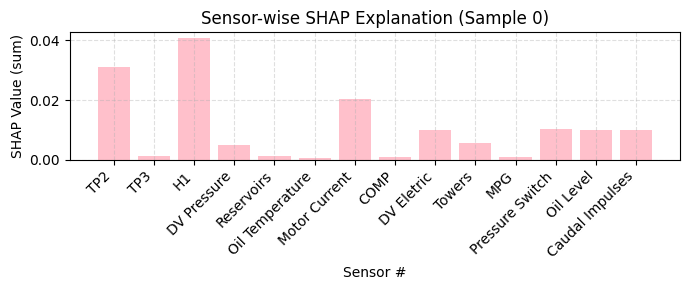

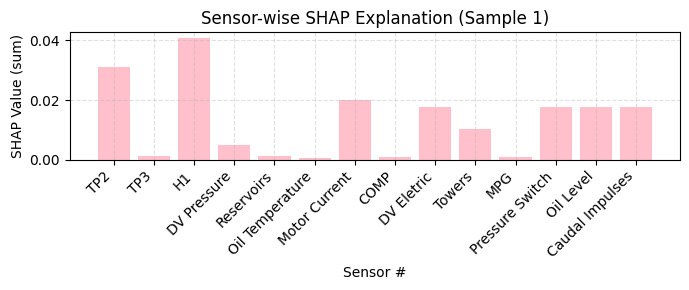

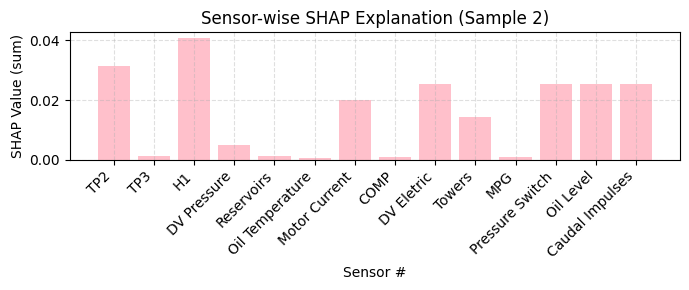

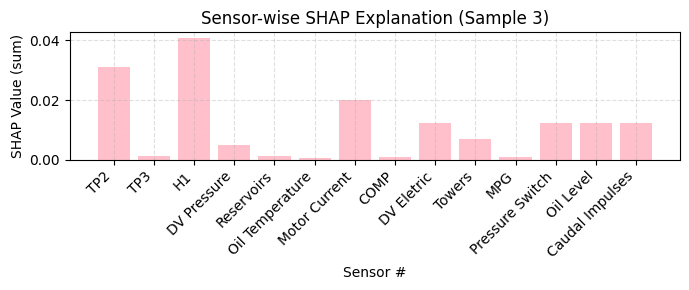

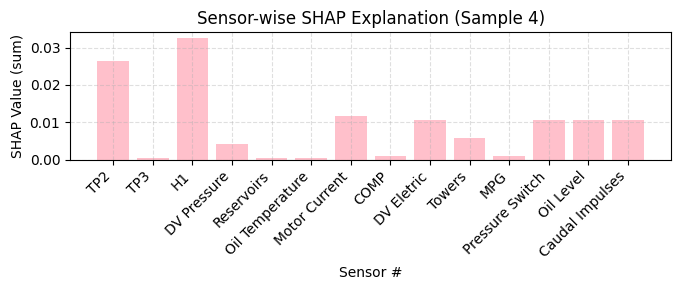

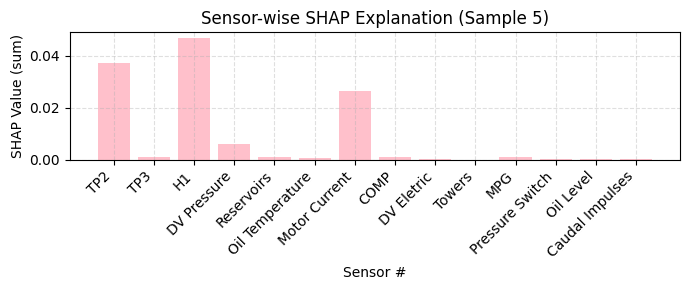

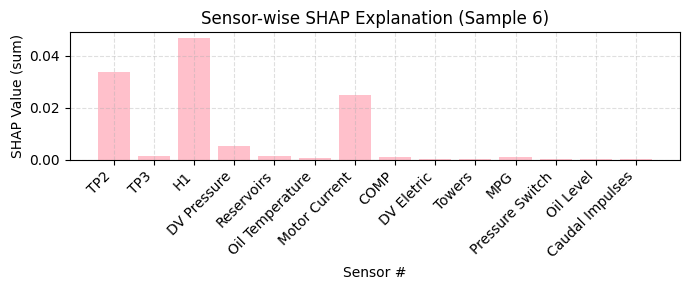

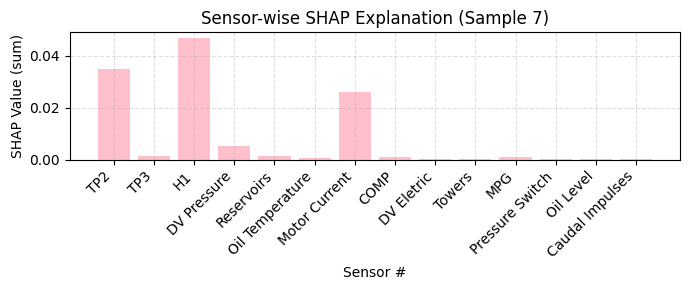

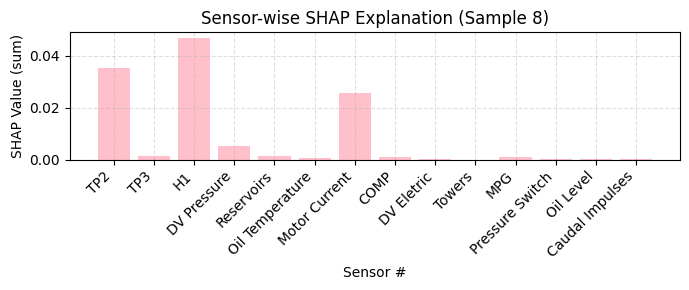

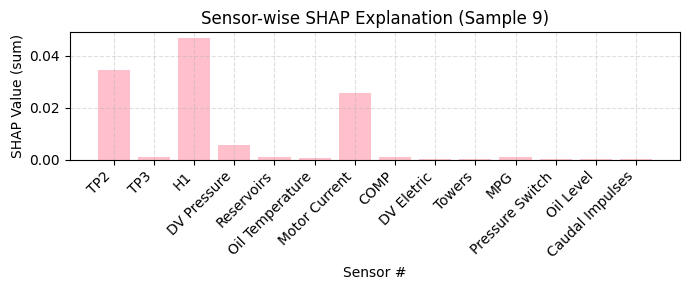

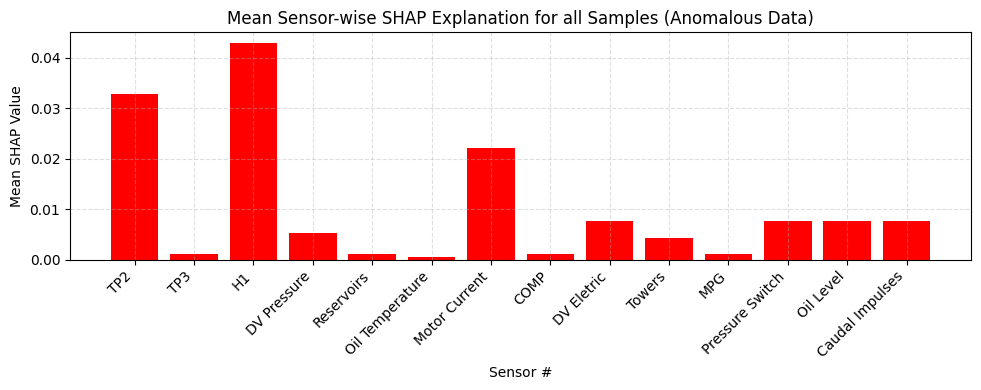

In [ ]:
def plot_sensor_shap_values(shap_values, sample_idx=0, agg_fn='sum', return_vals=False):
    """
    Plots SHAP values aggregated by sensor for a single sample.
    
    If return_vals=True, returns the aggregated SHAP values instead of plotting.
    """
    shap_vals = shap_values.values[sample_idx]  # shape: (100,)
    sensor_shap_vals = []

    for i in range(14):
        start = i * 7
        end = start + 7
        sensor_points = shap_vals[start:end]
        if agg_fn == 'sum':
            aggregated = np.sum(np.abs(sensor_points))
        else:
            aggregated = np.mean(np.abs(sensor_points))
        sensor_shap_vals.append(aggregated)

    if return_vals:
        return sensor_shap_vals

    sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                     'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                     'Oil Level','Caudal Impulses']

    plt.figure(figsize=(7, 3))
    plt.bar(range(1, 15), sensor_shap_vals, color='pink')
    plt.xlabel('Sensor #')
    plt.ylabel(f'SHAP Value ({agg_fn})')
    plt.title(f'Sensor-wise SHAP Explanation (Sample {sample_idx})')
    plt.xticks(range(1, 15), sensor_labels, rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals = np.mean(all_sensor_vals, axis=0)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals, color='red')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Anomalous Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### SHAP for good data

In [ ]:
X_train_sample = normal_train_data_normalized[-100:]

X_test = X_train_sample[np.random.choice(len(X_train_sample), size=10, replace=False)]

X_test = np.array(X_test)
X_test.shape  # (10, input_dim)

(10, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
shap_values.values.shape  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

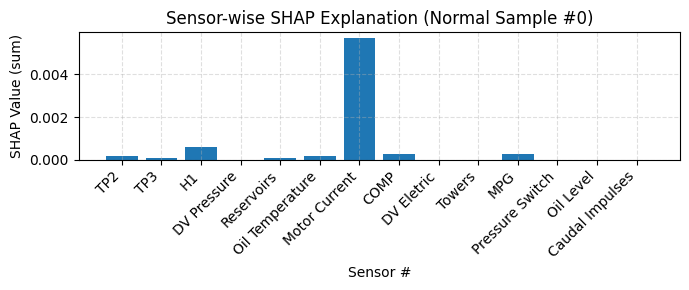

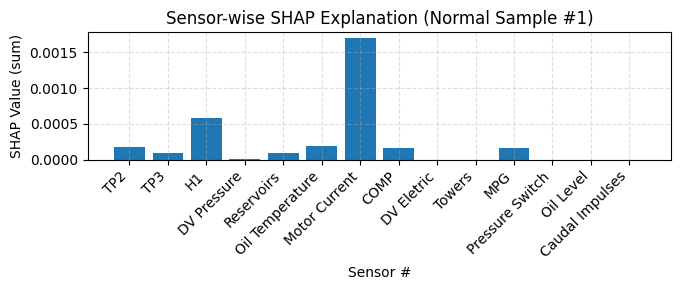

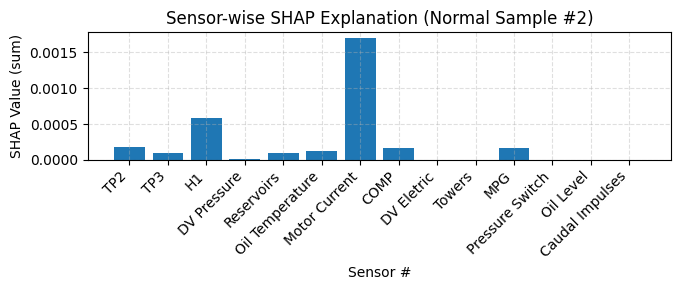

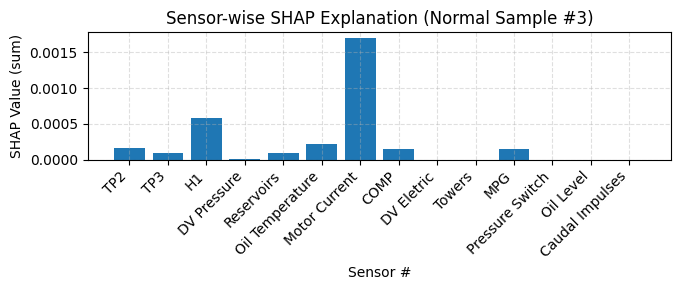

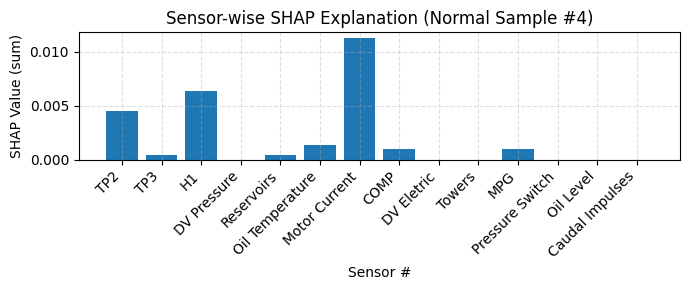

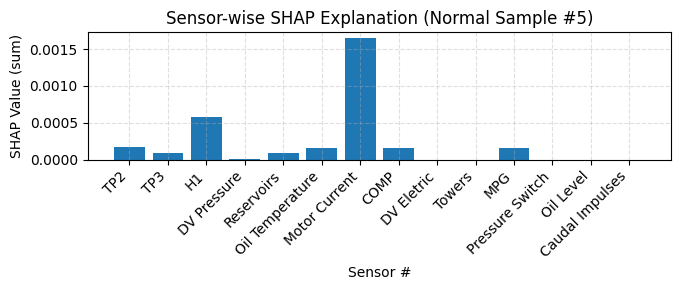

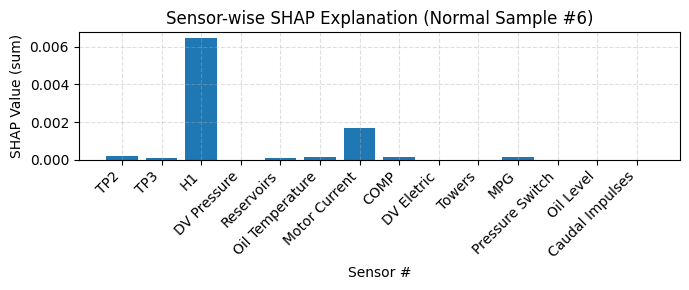

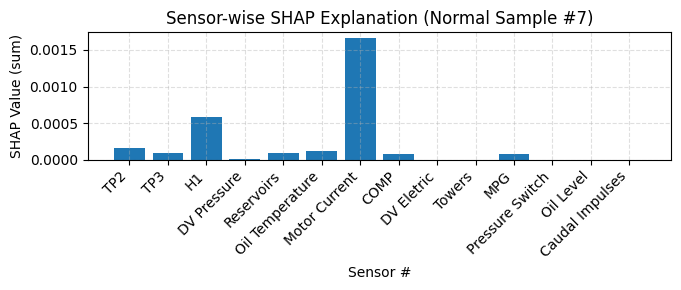

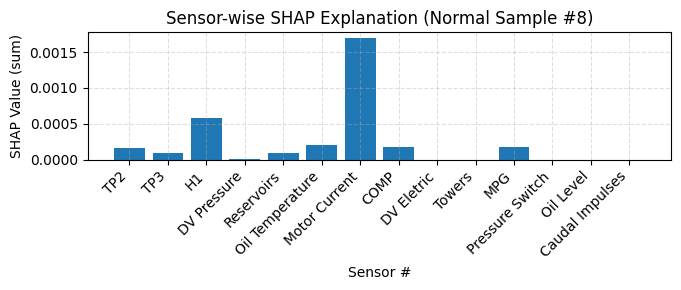

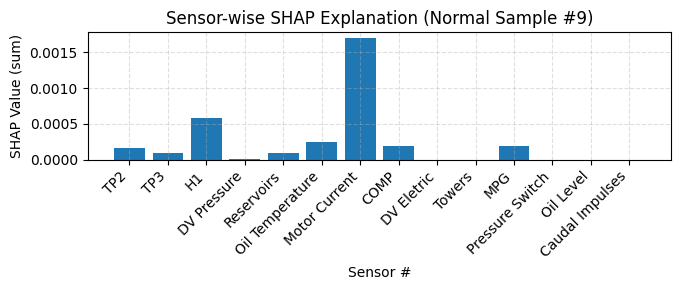

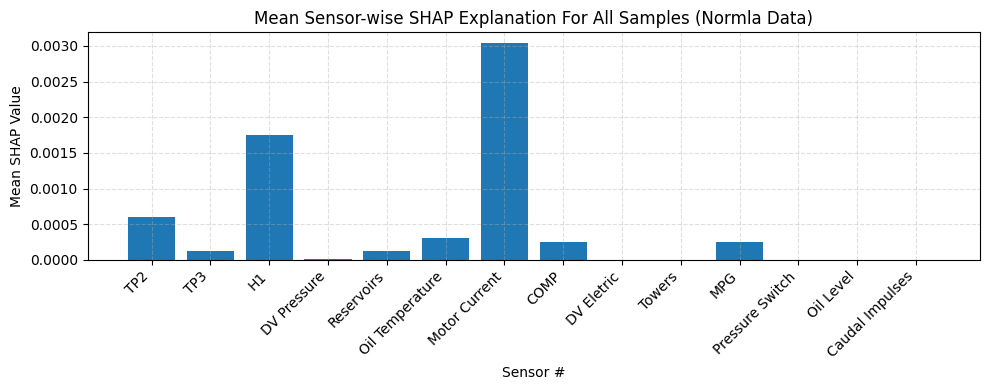

In [ ]:
def plot_sensor_shap_values(shap_values, sample_idx=0, agg_fn='sum', return_vals=False):
    """
    Plots SHAP values aggregated by sensor for a single sample.
    
    If return_vals=True, returns the aggregated SHAP values instead of plotting.
    """
    shap_vals = shap_values.values[sample_idx]  # shape: (100,)
    sensor_shap_vals = []

    for i in range(14):
        start = i * 7
        end = start + 7
        sensor_points = shap_vals[start:end]
        if agg_fn == 'sum':
            aggregated = np.sum(np.abs(sensor_points))
        else:
            aggregated = np.mean(np.abs(sensor_points))
        sensor_shap_vals.append(aggregated)

    if return_vals:
        return sensor_shap_vals

    sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                     'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                     'Oil Level','Caudal Impulses']

    plt.figure(figsize=(7, 3))
    plt.bar(range(1, 15), sensor_shap_vals)
    plt.xlabel('Sensor #')
    plt.ylabel(f'SHAP Value ({agg_fn})')
    plt.title(f'Sensor-wise SHAP Explanation (Normal Sample #{sample_idx})')
    plt.xticks(range(1, 15), sensor_labels, rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals = np.mean(all_sensor_vals, axis=0)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals)
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation For All Samples (Normla Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Verifying SHAP results

### SHAP w/ Synthetic Data

[[8.7355447e-01 9.7156394e-01 1.1374407e-03 1.3270142e-03 1.5165876e-03
  1.3270142e-03 1.3270142e-03 8.2679093e-01 9.5853770e-01 9.6000969e-01
  9.0186453e-01 8.5402358e-01 8.0569184e-01 7.6373899e-01 9.7943202e-04
  1.3712049e-03 9.6709114e-01 9.2027420e-01 8.8188046e-01 8.4368271e-01
  8.0999023e-01 1.4819205e-03 1.1855364e-03 1.4819205e-03 1.4819205e-03
  1.4819205e-03 1.4819205e-03 1.1855364e-03 8.2757771e-01 9.5860875e-01
  9.6032321e-01 9.0227771e-01 8.5476363e-01 8.0651474e-01 7.6463377e-01
  8.2805037e-01 9.2531466e-01 9.4528866e-01 9.0707755e-01 8.5844541e-01
  8.4324789e-01 8.0199730e-01 9.2911190e-01 9.7809631e-01 6.3042611e-01
  6.1847866e-01 6.1011547e-01 3.5842294e-03 3.1859814e-03 0.0000000e+00
  8.8495575e-03 1.0619469e-01 1.0619469e-01 1.0619469e-01 1.0619469e-01
  9.7345129e-02 9.4492437e-04 9.4492437e-04 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.6997839e-04 2.7005130e-04 6.7512825e-04
  1.6203078e-03 1.6203078e-03 1.6203078e-03 1.6203078e-03 1.4852

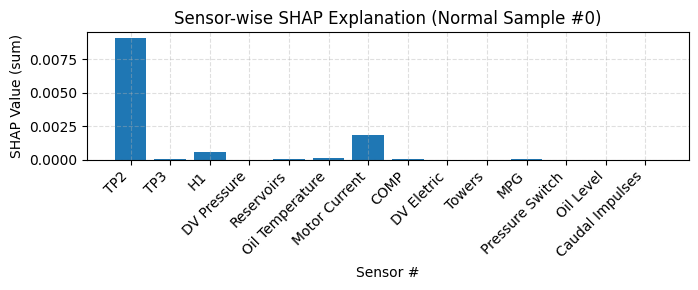

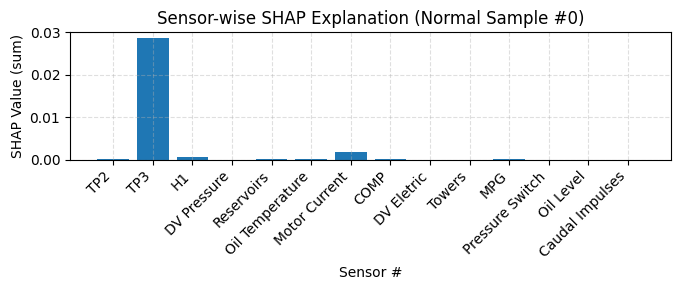

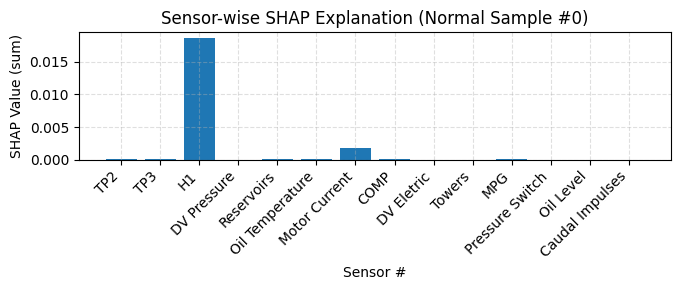

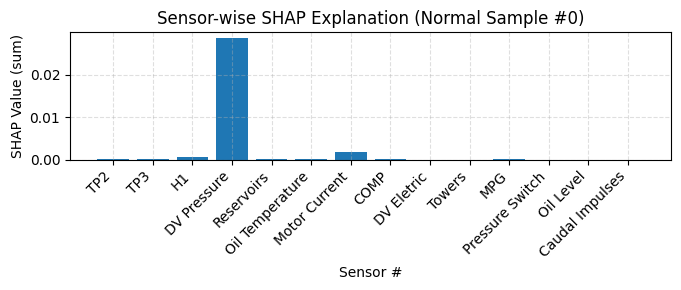

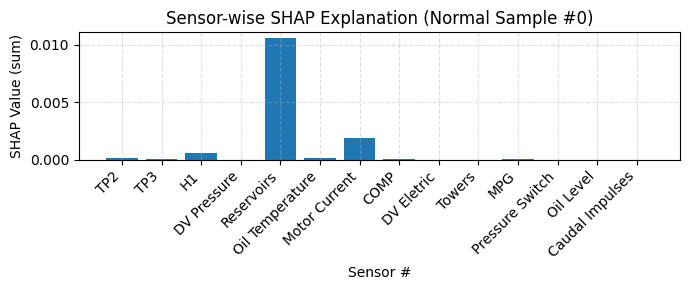

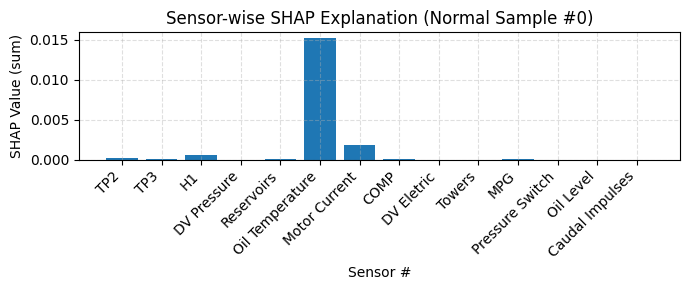

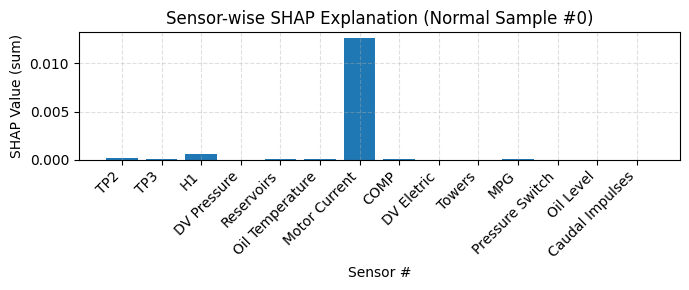

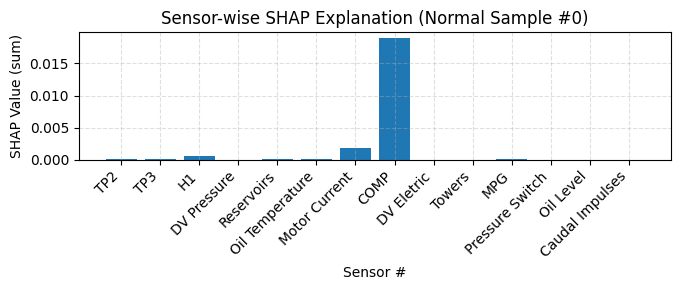

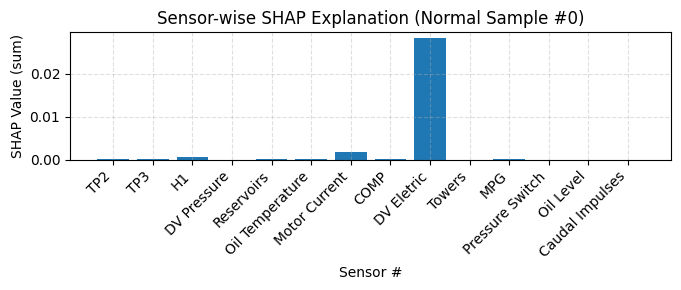

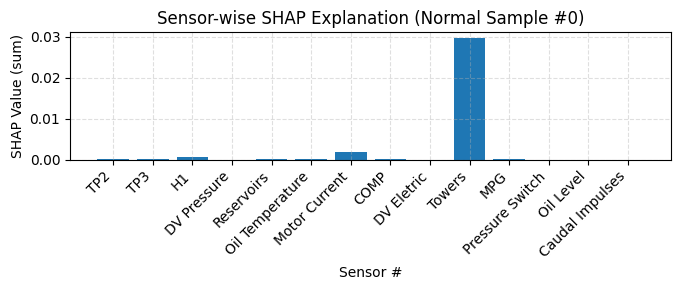

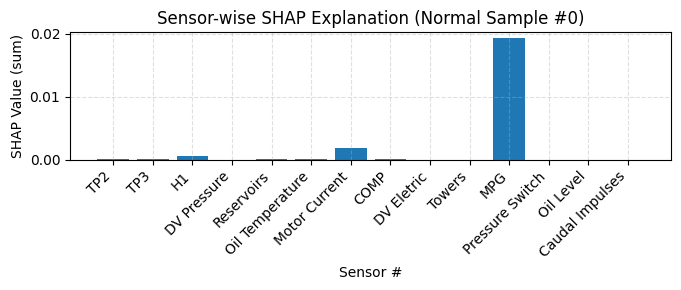

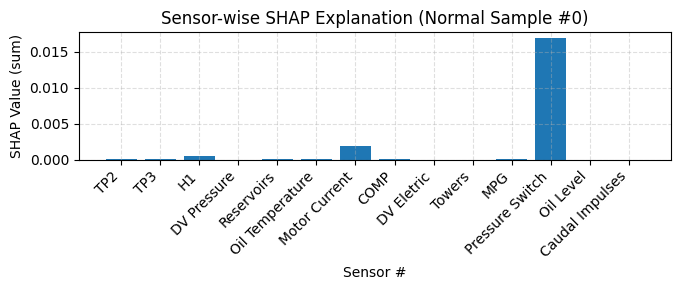

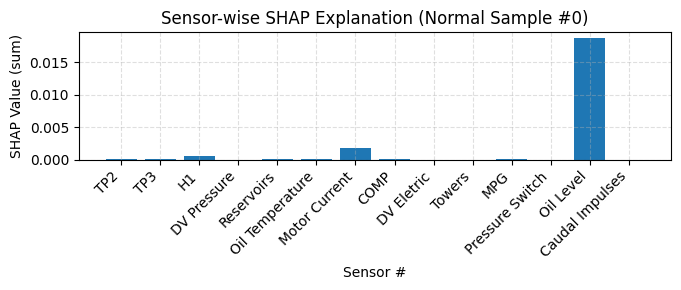

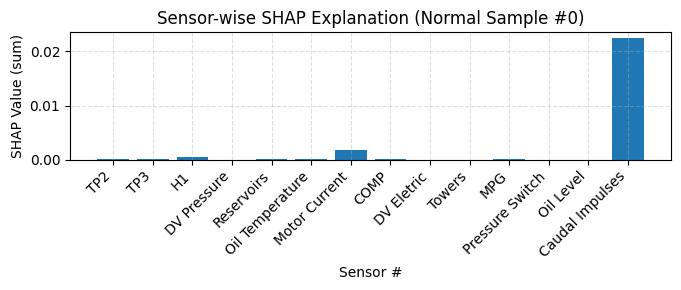

In [ ]:
# Create synthetic anomaly by corrupting one sensor's data
synthetic_sample = X_train_sample[8:9].copy()
print(synthetic_sample) # Add large offset

for i in range(14):
    synthetic_sample_aux = synthetic_sample.copy()
    synthetic_sample_aux[0][i*7:(i+1)*7] = np.random.rand(7)

    # Compute SHAP for this sample
    synth_shap = explainer(synthetic_sample_aux)
    plot_sensor_shap_values(synth_shap)

## Pinpointing sensors

### Background Data

In [ ]:
timestamps[0]

Timestamp('2020-02-01 00:23:08')

In [ ]:
# Getting the index of the first anomalous cycles for each failure
print(f"First failure: {np.where(timestamps >= '2020-04-18')[0][0]}")
print(f"Second failure: {np.where(timestamps >= '2020-05-29 23:30:00')[0][0]}")
print(f"Third failure: {np.where(timestamps >= '2020-06-05 10:00:00')[0][0]}")
print(f"Fourth failure: {np.where(timestamps >= '2020-07-15 14:30:00')[0][0]}")


First failure: 3679
Second failure: 5667
Third failure: 6069
Fourth failure: 8597


In [ ]:
normal_train_data_normalized.shape

(1773, 100)

In [ ]:
X_train_sample = normal_train_data_normalized

X_test = X_train_sample[np.random.choice(len(X_train_sample), size=150, replace=False)]

X_test = np.array(X_test)
X_test.shape  # (10, input_dim)

(150, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
shap_values.values.shape  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

PermutationExplainer explainer: 151it [00:28,  3.81it/s]                         


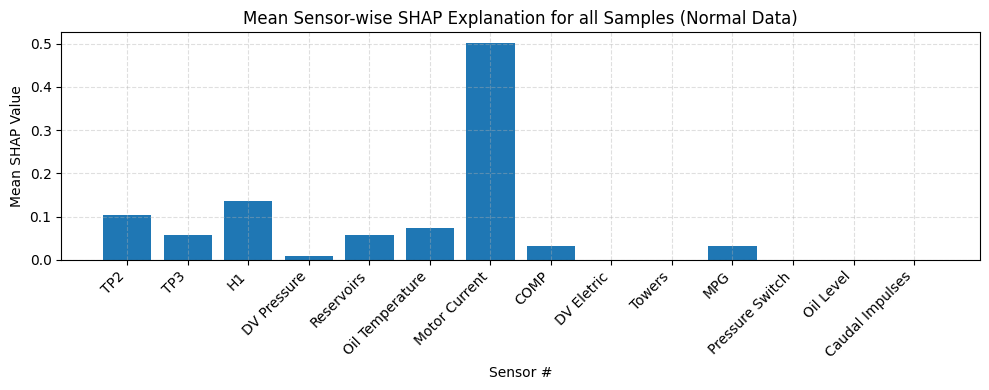

In [ ]:
def plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=0, agg_fn='sum', return_vals=False):
    """
    Plots SHAP values aggregated by sensor for a single sample.
    
    If return_vals=True, returns the aggregated SHAP values instead of plotting.
    """
    shap_vals = shap_values.values[sample_idx]  # shape: (100,)
    sensor_shap_vals = []

    for i in range(14):
        start = i * 7
        end = start + 7
        sensor_points = shap_vals[start:end]
        if agg_fn == 'sum':
            aggregated = np.sum(np.abs(sensor_points))
        else:
            aggregated = np.mean(np.abs(sensor_points))
        sensor_shap_vals.append(aggregated)

    if return_vals:
        return sensor_shap_vals

# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals = np.mean(all_sensor_vals, axis=0)
mean_vals_normalized = mean_vals/sum(mean_vals)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals_normalized)
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Normal Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
mean_vals_normalized

array([1.04323152e-01, 5.69849380e-02, 1.35554657e-01, 9.15268813e-03,
       5.69664843e-02, 7.44355420e-02, 5.00805004e-01, 3.08726422e-02,
       9.88534563e-07, 8.91872589e-06, 3.08712927e-02, 7.90873445e-06,
       7.89352605e-06, 7.89044715e-06])

#### Anomaly 1 !!part of validation set!!

In [ ]:
X_train_sample = normal_train_data_normalized

X_test = shap_test_data_1
X_test.shape  # (10, input_dim)

(1, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
print(shap_values.values.shape)  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

(1, 100)


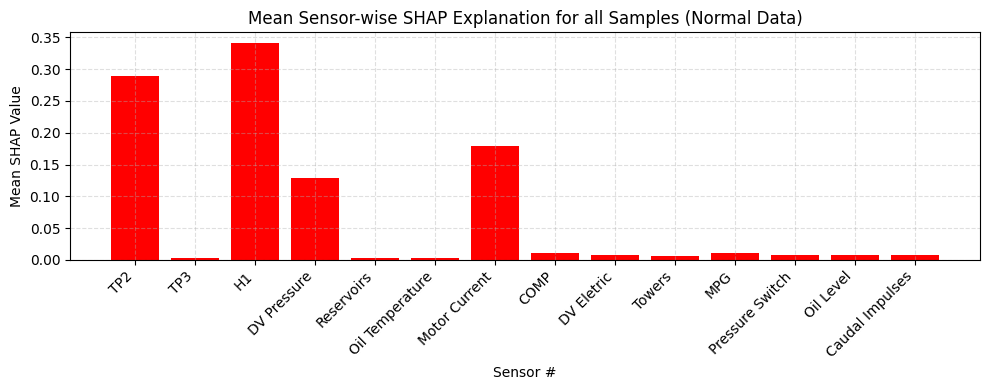

In [ ]:
# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals_anomaly =  all_sensor_vals[0] #no need to do the mean bc it's already only 1 cycle
mean_vals_anomaly_normalized = mean_vals_anomaly/sum(mean_vals_anomaly)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals_anomaly_normalized, color='red')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Normal Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

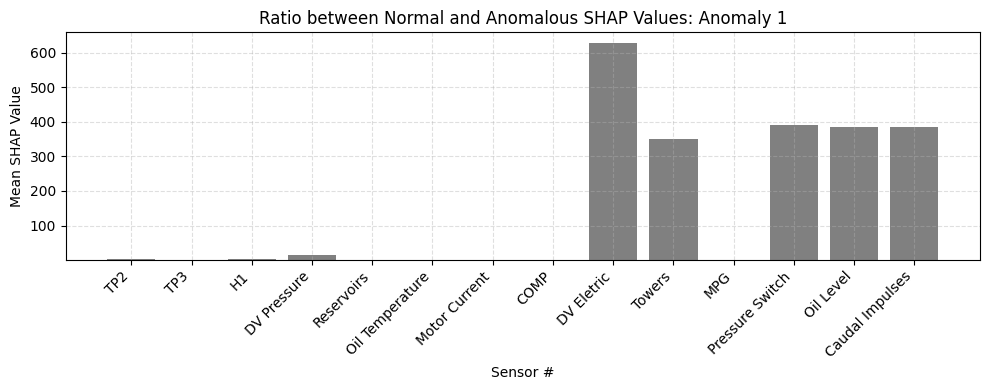

In [ ]:
epsilon = 1e-5
plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), ((mean_vals_anomaly_normalized + epsilon)/(mean_vals_normalized + epsilon)), color='gray')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Ratio between Normal and Anomalous SHAP Values: Anomaly 1')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.ylim((1))
#plt.savefig('shap_mean_anomaly.png', transparent=True, facecolor='none', edgecolor='none')
plt.show()

#### Anomaly 2

In [ ]:
X_train_sample = normal_train_data_normalized

X_test = shap_test_data_2
X_test.shape  # (10, input_dim)

(1, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
print(shap_values.values.shape)  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

(1, 100)


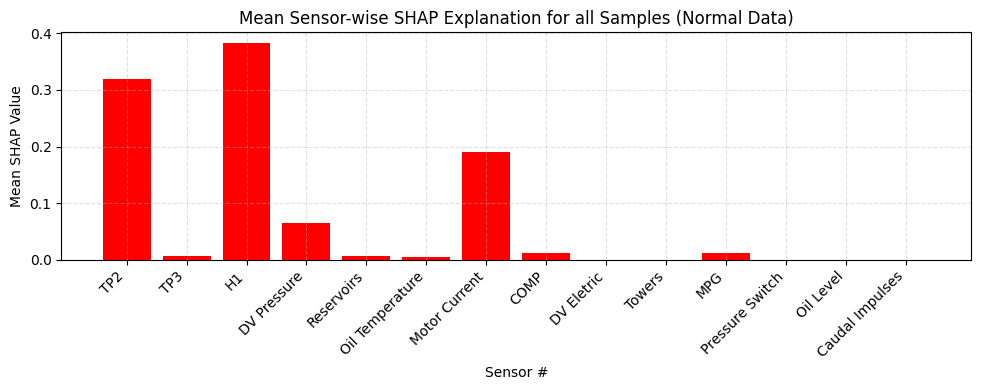

In [ ]:
# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals_anomaly =  all_sensor_vals[0] #no need to do the mean bc it's already only 1 cycle
mean_vals_anomaly_normalized = mean_vals_anomaly/sum(mean_vals_anomaly)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals_anomaly_normalized, color='red')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Normal Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

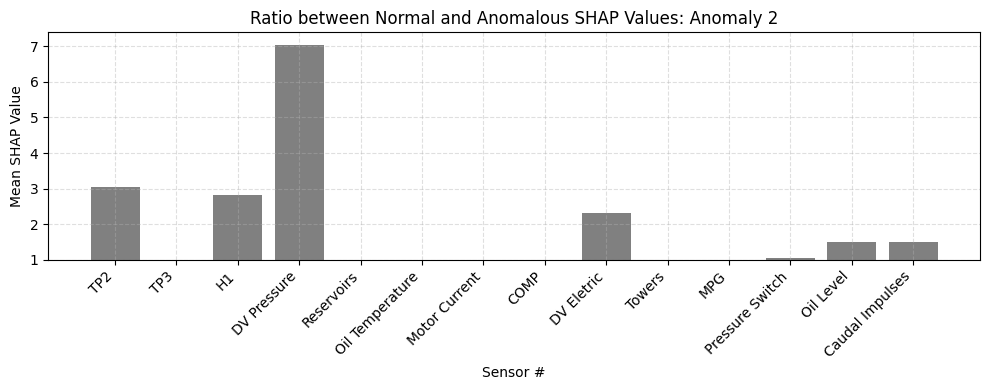

In [ ]:

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), ((mean_vals_anomaly_normalized + epsilon)/(mean_vals_normalized + epsilon)), color='gray')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Ratio between Normal and Anomalous SHAP Values: Anomaly 2')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.ylim((1))
#plt.savefig('shap_mean_anomaly.png', transparent=True, facecolor='none', edgecolor='none')
plt.show()

#### Anomaly 3

In [ ]:
X_train_sample = normal_train_data_normalized

X_test = shap_test_data_3
X_test.shape  # (10, input_dim)

(1, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
print(shap_values.values.shape)  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

(1, 100)


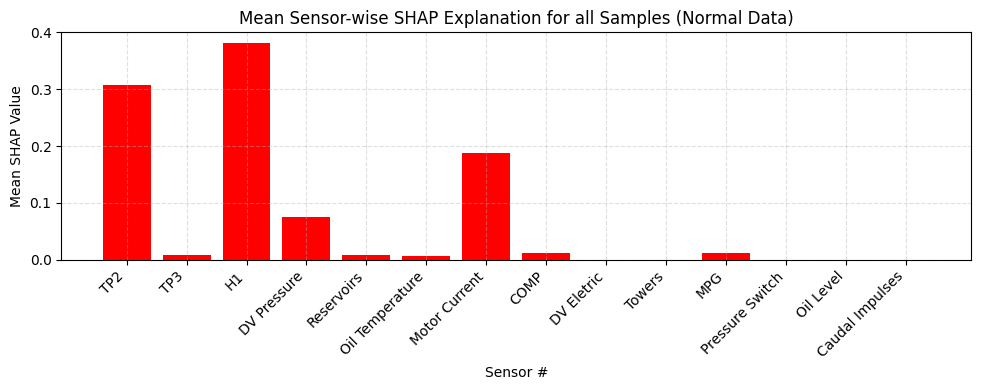

In [ ]:
# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals_anomaly =  all_sensor_vals[0] #no need to do the mean bc it's already only 1 cycle
mean_vals_anomaly_normalized = mean_vals_anomaly/sum(mean_vals_anomaly)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals_anomaly_normalized, color='red')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Normal Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

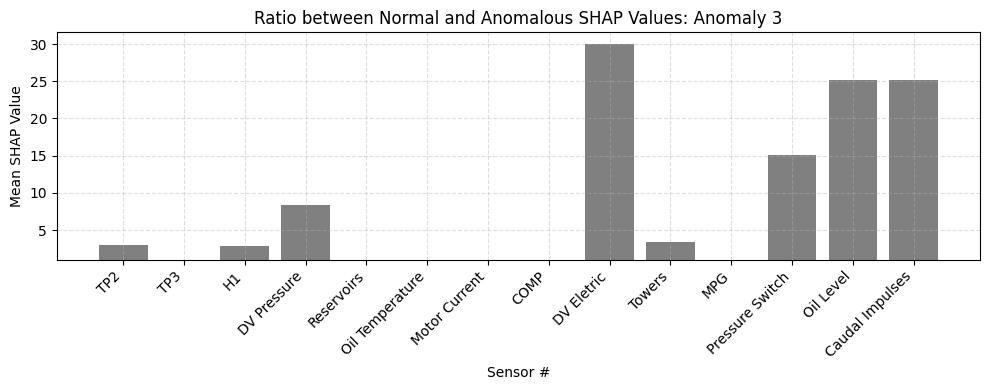

In [ ]:

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), ((mean_vals_anomaly_normalized + epsilon)/(mean_vals_normalized + epsilon)), color='gray')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Ratio between Normal and Anomalous SHAP Values: Anomaly 3')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.ylim((1))
#plt.savefig('shap_mean_anomaly.png', transparent=True, facecolor='none', edgecolor='none')
plt.show()

#### Anomaly 4

In [ ]:
X_train_sample = normal_train_data_normalized

X_test = shap_test_data_4
X_test.shape  # (10, input_dim)

(1, 100)

In [ ]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
print(shap_values.values.shape)  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

(1, 100)


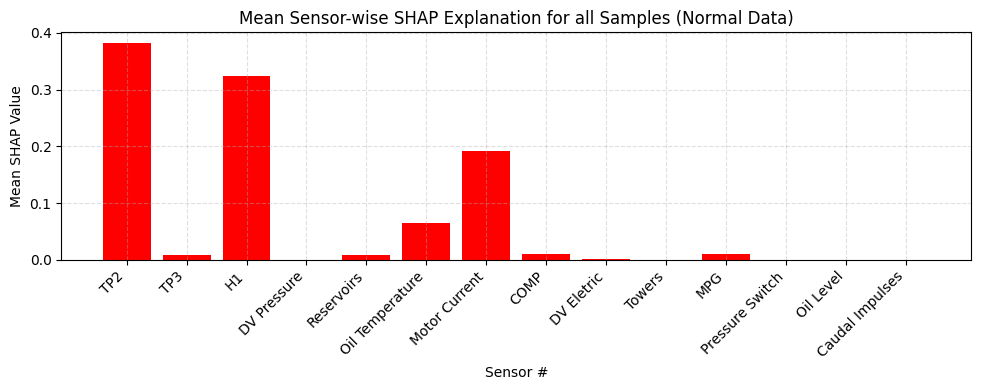

In [ ]:
# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values_normal_pinpoint(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals_anomaly =  all_sensor_vals[0] #no need to do the mean bc it's already only 1 cycle
mean_vals_anomaly_normalized = mean_vals_anomaly/sum(mean_vals_anomaly)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals_anomaly_normalized, color='red')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Normal Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

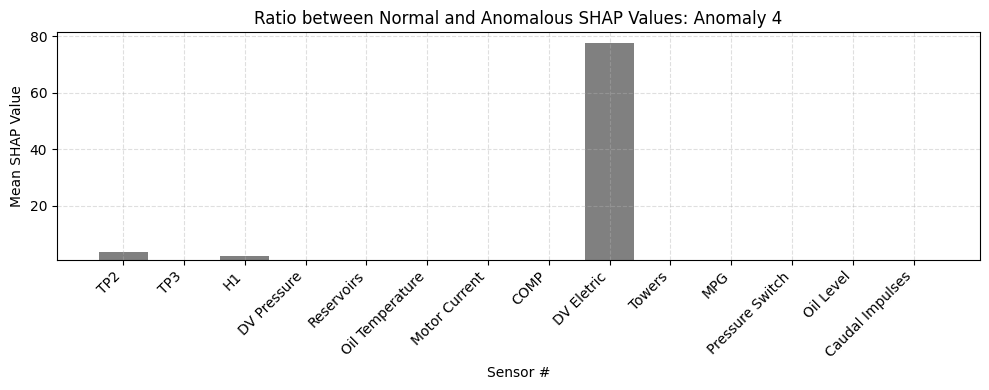

In [ ]:

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), ((mean_vals_anomaly_normalized + epsilon)/(mean_vals_normalized + epsilon)), color='gray')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Ratio between Normal and Anomalous SHAP Values: Anomaly 4')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.ylim((1))
#plt.savefig('shap_mean_anomaly.png', transparent=True, facecolor='none', edgecolor='none')
plt.show()